In [2]:
import numpy as np
from lib.dvr2d import *
from lib.utils import *
from lib.pot_gen import *
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, BOBYQA, NELDER_MEAD, SNOBFIT
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PrimitiveOp
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 300

%load_ext autoreload

In [3]:
pot = get_pot('mgnh.txt', False)

In [5]:
%autoreload
# 32 points
dvr_options = {
    'type': 'jacobi',
    'N_R': 20, 
    'N_theta': 4,
    'l': 1,
    'K_max': 0,
    'r_min': 3,
    'r_max': 6, 
    'trunc': 0,
    'J': 0
}

# 64 points
# dvr_options = {
#     'type': 'jacobi',
#     'J': 0,
#     'N_R': 40, 
#     'N_theta': 4,
#     'l': 1,
#     'K_max': 0,
#     'r_min': 3,
#     'r_max': 9, 
#     'trunc': 0
# }

Rs_DVR, Xs_K = get_DVR_Rtheta(dvr_options, mgnh_params)
Rs_angs = Rs_DVR * mgnh_params['S'] * au_to_angs
print(Rs_angs)
print(Rs_angs.shape)
N_R_lim = Rs_angs.shape[0]

h_dvr = get_ham_DVR(pot, dvr_options, mgnh_params) * hartree
print(h_dvr.shape)
eigvals, eigvecs = np.linalg.eigh(h_dvr)
print(eigvals[:5])

[3.13861624 3.325217   3.5800952  3.90510423 4.30216693 4.77363497
 5.32242138 5.95212566]
(8,)
(32, 32)
[-88.19579902 -62.92776669 -54.96143699 -40.01587319 -32.37120608]


<BarContainer object of 32 artists>

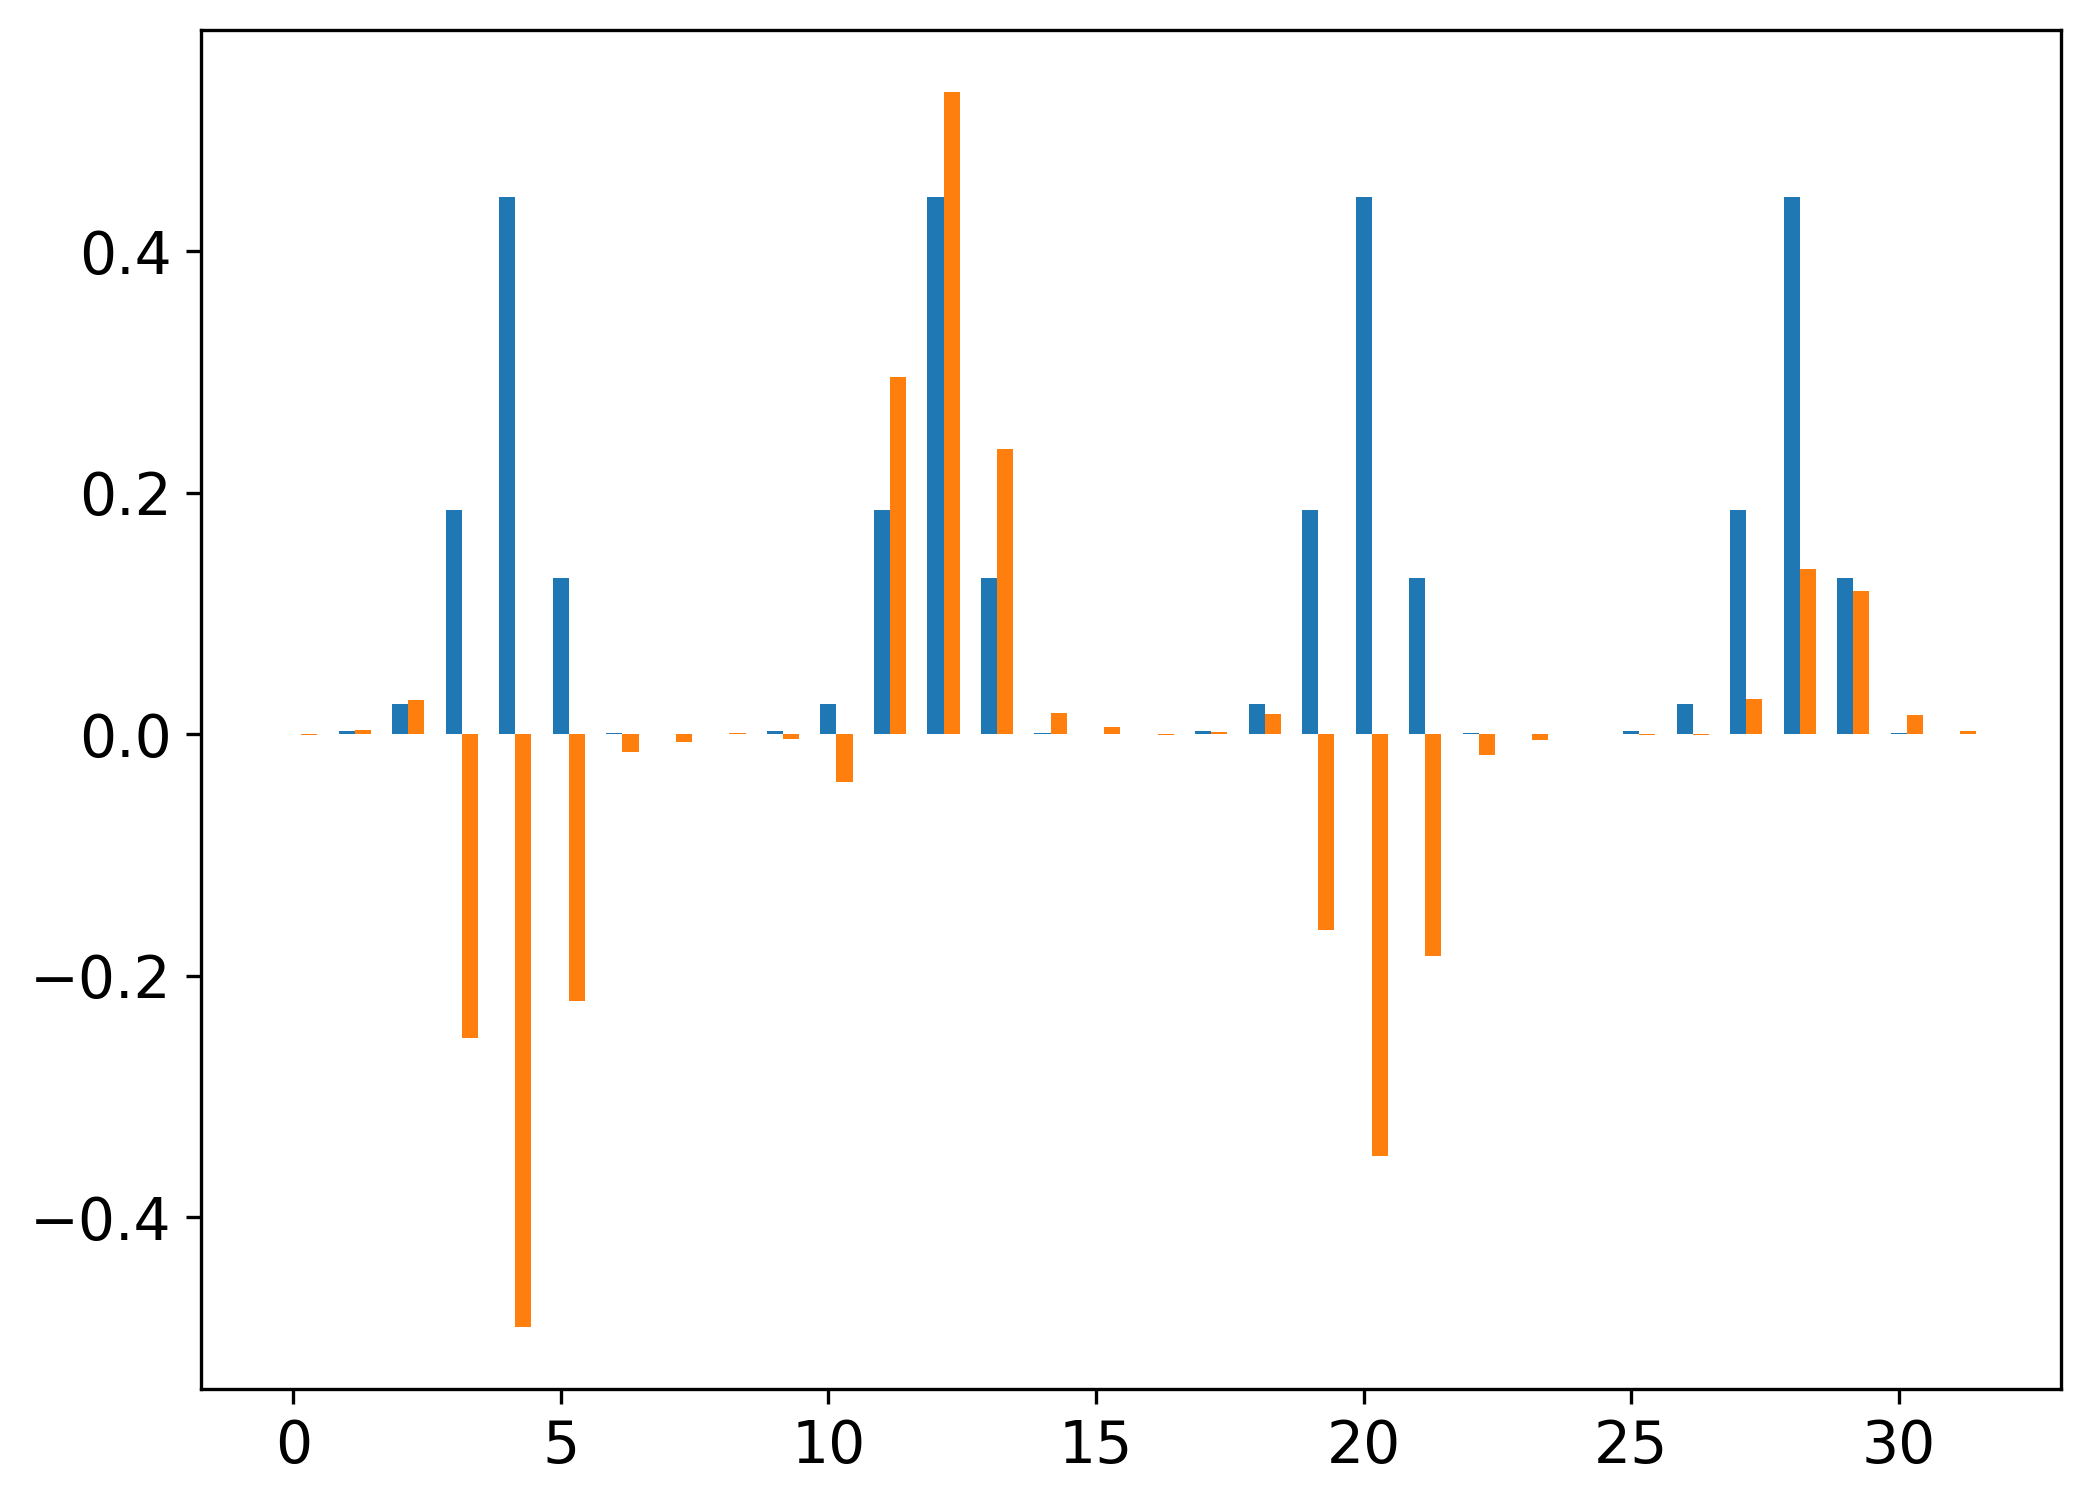

In [5]:
from scipy.stats import norm

eigvec_approx = norm.pdf(Rs_grid[Vs <= v_thresh], loc=Rs_grid[np.argmin(Vs[Vs <= v_thresh])], scale=0.3)
eigvec_approx /= np.linalg.norm(eigvec_approx)

plt.bar(np.array(range(len(eigvecs))), eigvec_approx, width=0.3)
plt.bar(np.array(range(len(eigvecs))) + 0.3, eigvecs.T[0], width=0.3)

In [6]:
h_dvr_pauli = pauli_decompose(h_dvr)

print(np.allclose(h_dvr, h_dvr_pauli.to_matrix()))

print(h_dvr.shape)
print(h_dvr_pauli.coeffs.shape)

c:\Users\kasna\OneDrive - UBC\arc\root\project\dvr_vqe\2d\lib\utils.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  coefs[i] = np.trace(np.dot(p.to_matrix(), h)) / 2**num_qubits


True
(32, 32)
(183,)


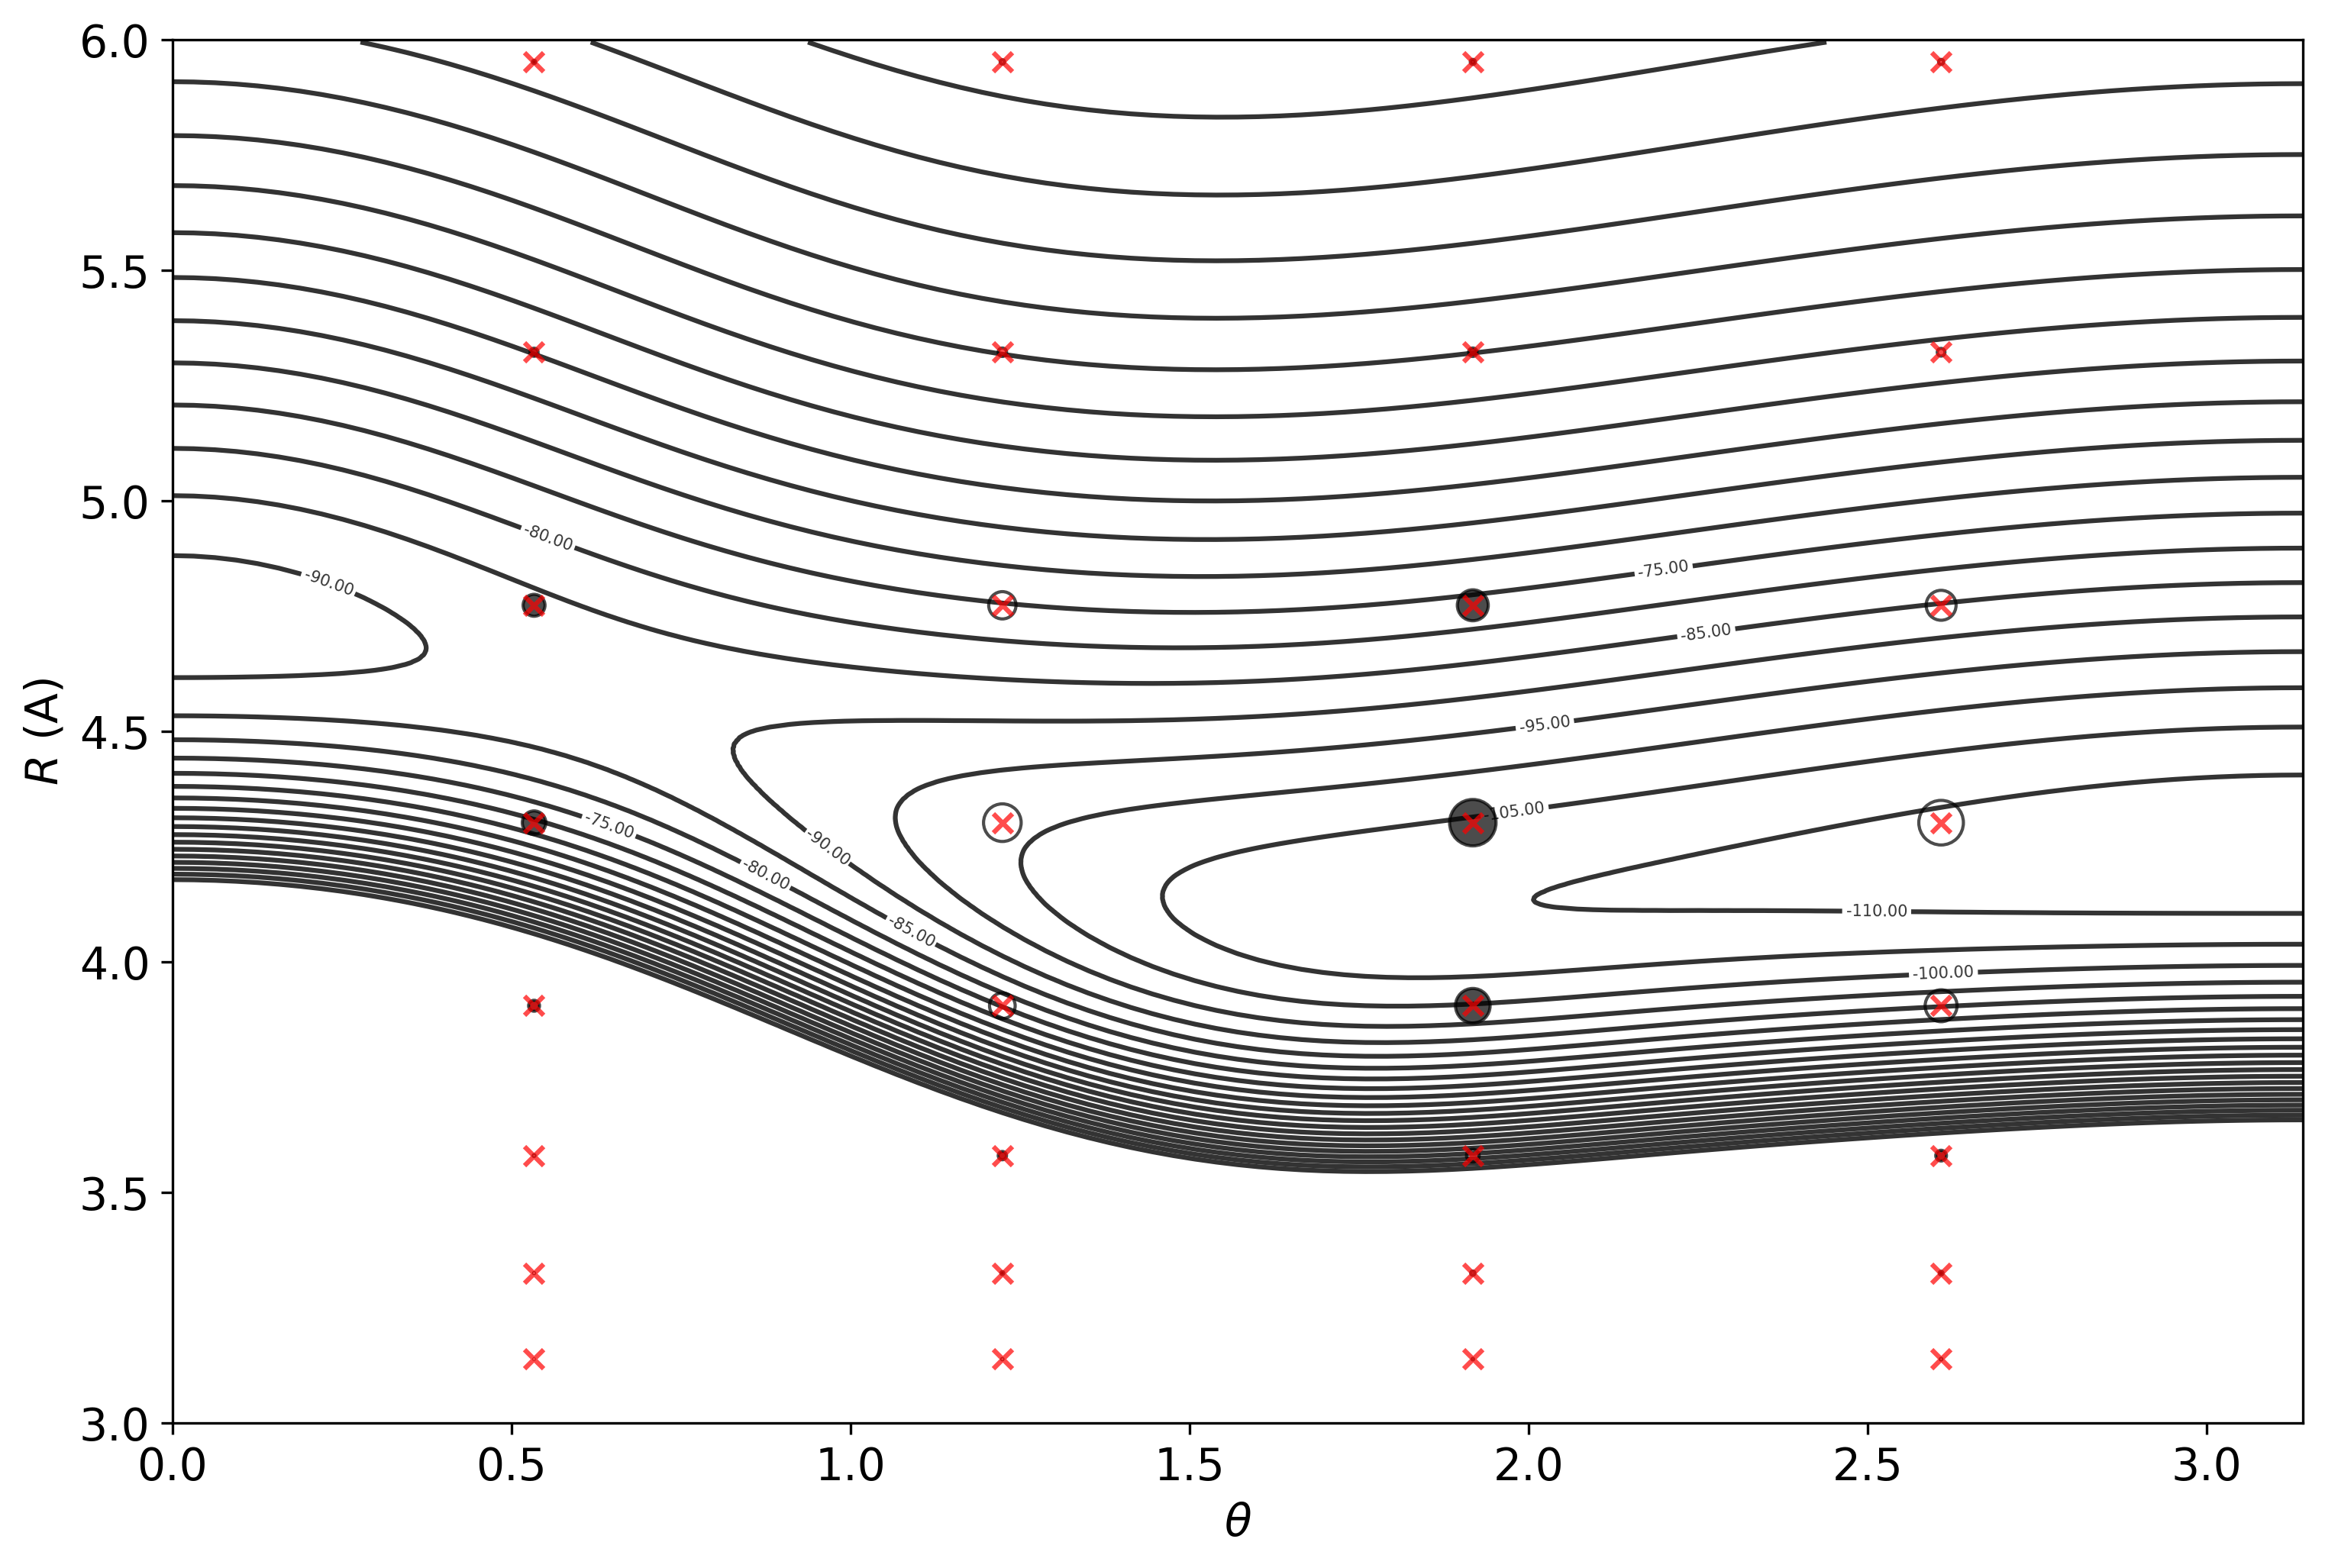

In [72]:
cmap = plt.get_cmap('tab10')
theta_p, r_p, v_p = theta[v < 0], r[v < 0], v[v < 0]

p = plt.tricontour(theta_p[r_p < 6], r_p[r_p < 6], v_p[r_p < 6], levels=np.linspace(-110, 0, 23), colors='black', linestyles='solid', alpha=0.8)
# plt.plot(theta[ind_min1], r[ind_min1], 'x', c='black')
# plt.plot(theta[ind_min2], r[ind_min2], 'x', c='black')
# plt.plot(1.8754889808102941, 3.897, 'o', c='black')
Rs_grid, Xs_grid = np.meshgrid(Rs_DVR * mgnh_params['S'] * au_to_angs, np.arccos(Xs_K[0]))
Rs_grid, Xs_grid = Rs_grid.flatten(), Xs_grid.flatten()

labels = p.levels[:-15:]
plt.clabel(p, inline=1, fontsize=5, levels=labels, fmt='%.2f', use_clabeltext=True)
plt.ylim()
plt.xlabel('$\\theta$')
plt.ylabel('$R$ (A)')
plt.ylim((3, 6))
plt.xlim((0, np.pi))

# offset = 0.05
# plt.bar(np.arccos(Xs_K[0]), eigvecs5.T[0][::5] * 1.5, bottom=4, width=0.05, color='black', alpha=0.4)
# plt.bar(np.arccos(Xs_K[0]) + 1 * offset, eigvecs5.T[0][1::5] * 1.5, bottom=4, width=0.05, color='black', alpha=0.4)
# plt.bar(np.arccos(Xs_K[0]) + 2 * offset, eigvecs5.T[0][2::5] * 1.5, bottom=4, width=0.05, color='black', alpha=0.4)
# plt.bar(np.arccos(Xs_K[0]) + 3 * offset, eigvecs5.T[0][3::5] * 1.5, bottom=4, width=0.05, color='black', alpha=0.4)
# plt.bar(np.arccos(Xs_K[0]) + 4 * offset, eigvecs5.T[0][4::5] * 1.5, bottom=4, width=0.05, color='black', alpha=0.4)
# plt.axhline(4.0, linestyle='dashed', c='black', linewidth=0.2)

for i in range(N_theta):
    evec = eigvecs.T[0][i * N_R_lim:(i+1) * N_R_lim]
    epos = np.where(evec >=0, evec, 0)
    eneg = np.where(evec <0, -evec, 0)
    plt.scatter(np.repeat(np.arccos(Xs_K[0][i]), N_R_lim), Rs_DVR * mgnh_params['S'] * au_to_angs, marker='o', facecolors='black', edgecolors='black', s=epos * 400, zorder=20, alpha=0.7)
    plt.scatter(np.repeat(np.arccos(Xs_K[0][i]), N_R_lim), Rs_DVR * mgnh_params['S'] * au_to_angs, facecolors='none', edgecolors='black', s=eneg * 400, alpha=0.7, zorder=20)
plt.scatter(Xs_grid[Vs <= v_thresh], Rs_grid[Vs <= v_thresh], marker='x', c='red', zorder=30, alpha=0.7)

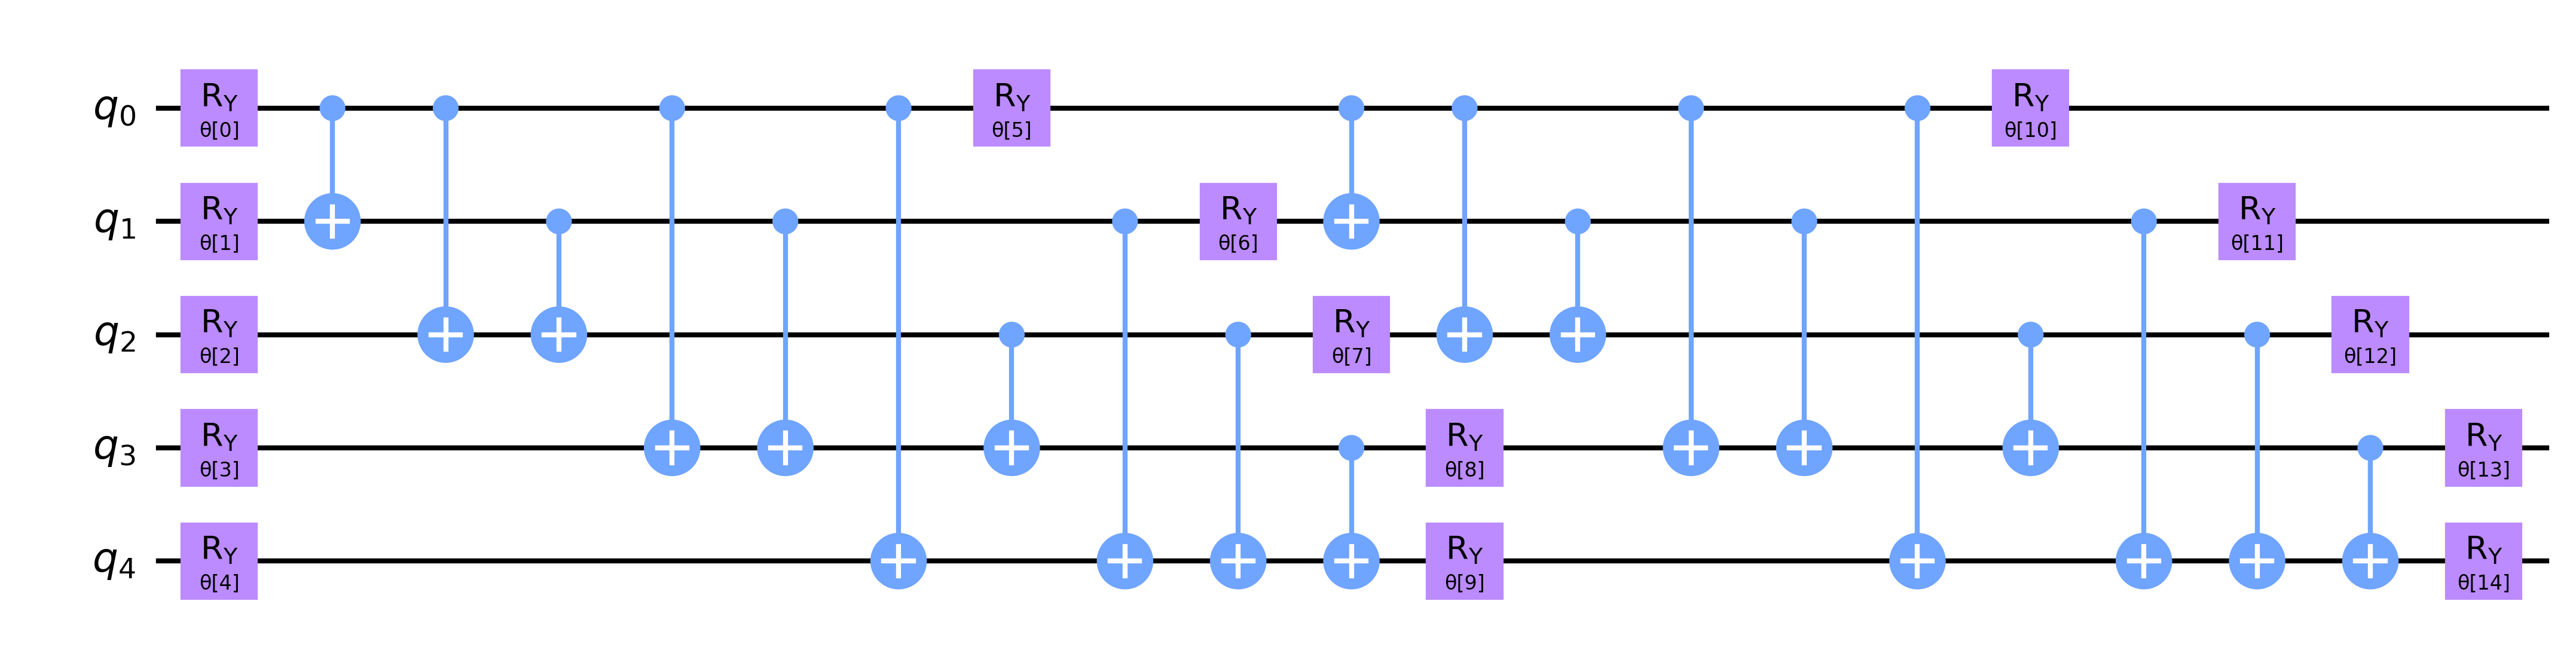

In [74]:
ansatz1 = TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks='cx', entanglement='full', reps=2).decompose()
print(ansatz1.depth())
ansatz1.draw(output='mpl', fold=-1)
# print(ansatz)

In [75]:
# optimizers = [SLSQP(maxiter=1000)]
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts1 = np.empty([len(optimizers)], dtype=object)
converge_vals1 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res1 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz1, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res1 is None) or (values[-1] < best_res1):
            best_res1 = values[-1]
            converge_cnts1[i] = np.asarray(counts)
            converge_vals1[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
1565, -86.88591879630907
8000, -85.69281932917391
1526, -86.88629140972608
Optimizer: L_BFGS_B        
2768, -86.88752345427446
7200, -86.88880608240322
1376, -86.88835703832076
Optimizer: SLSQP        
513, -86.888803909513336
1308, -86.80392866947315
1219, -86.88834976482876
Optimizer: NELDER_MEAD        
5236, -84.42822693680816
7786, -81.30275506137633
4160, -86.834200554517176

Optimization complete      


COBYLA -86.88629140972608 1.340560635919303
L_BFGS_B -86.88880608240322 1.3380459632421662
SLSQP -86.88880390951333 1.338048136132059
NELDER_MEAD -86.8342005545171 1.3926514911282908
0.031053018200125848


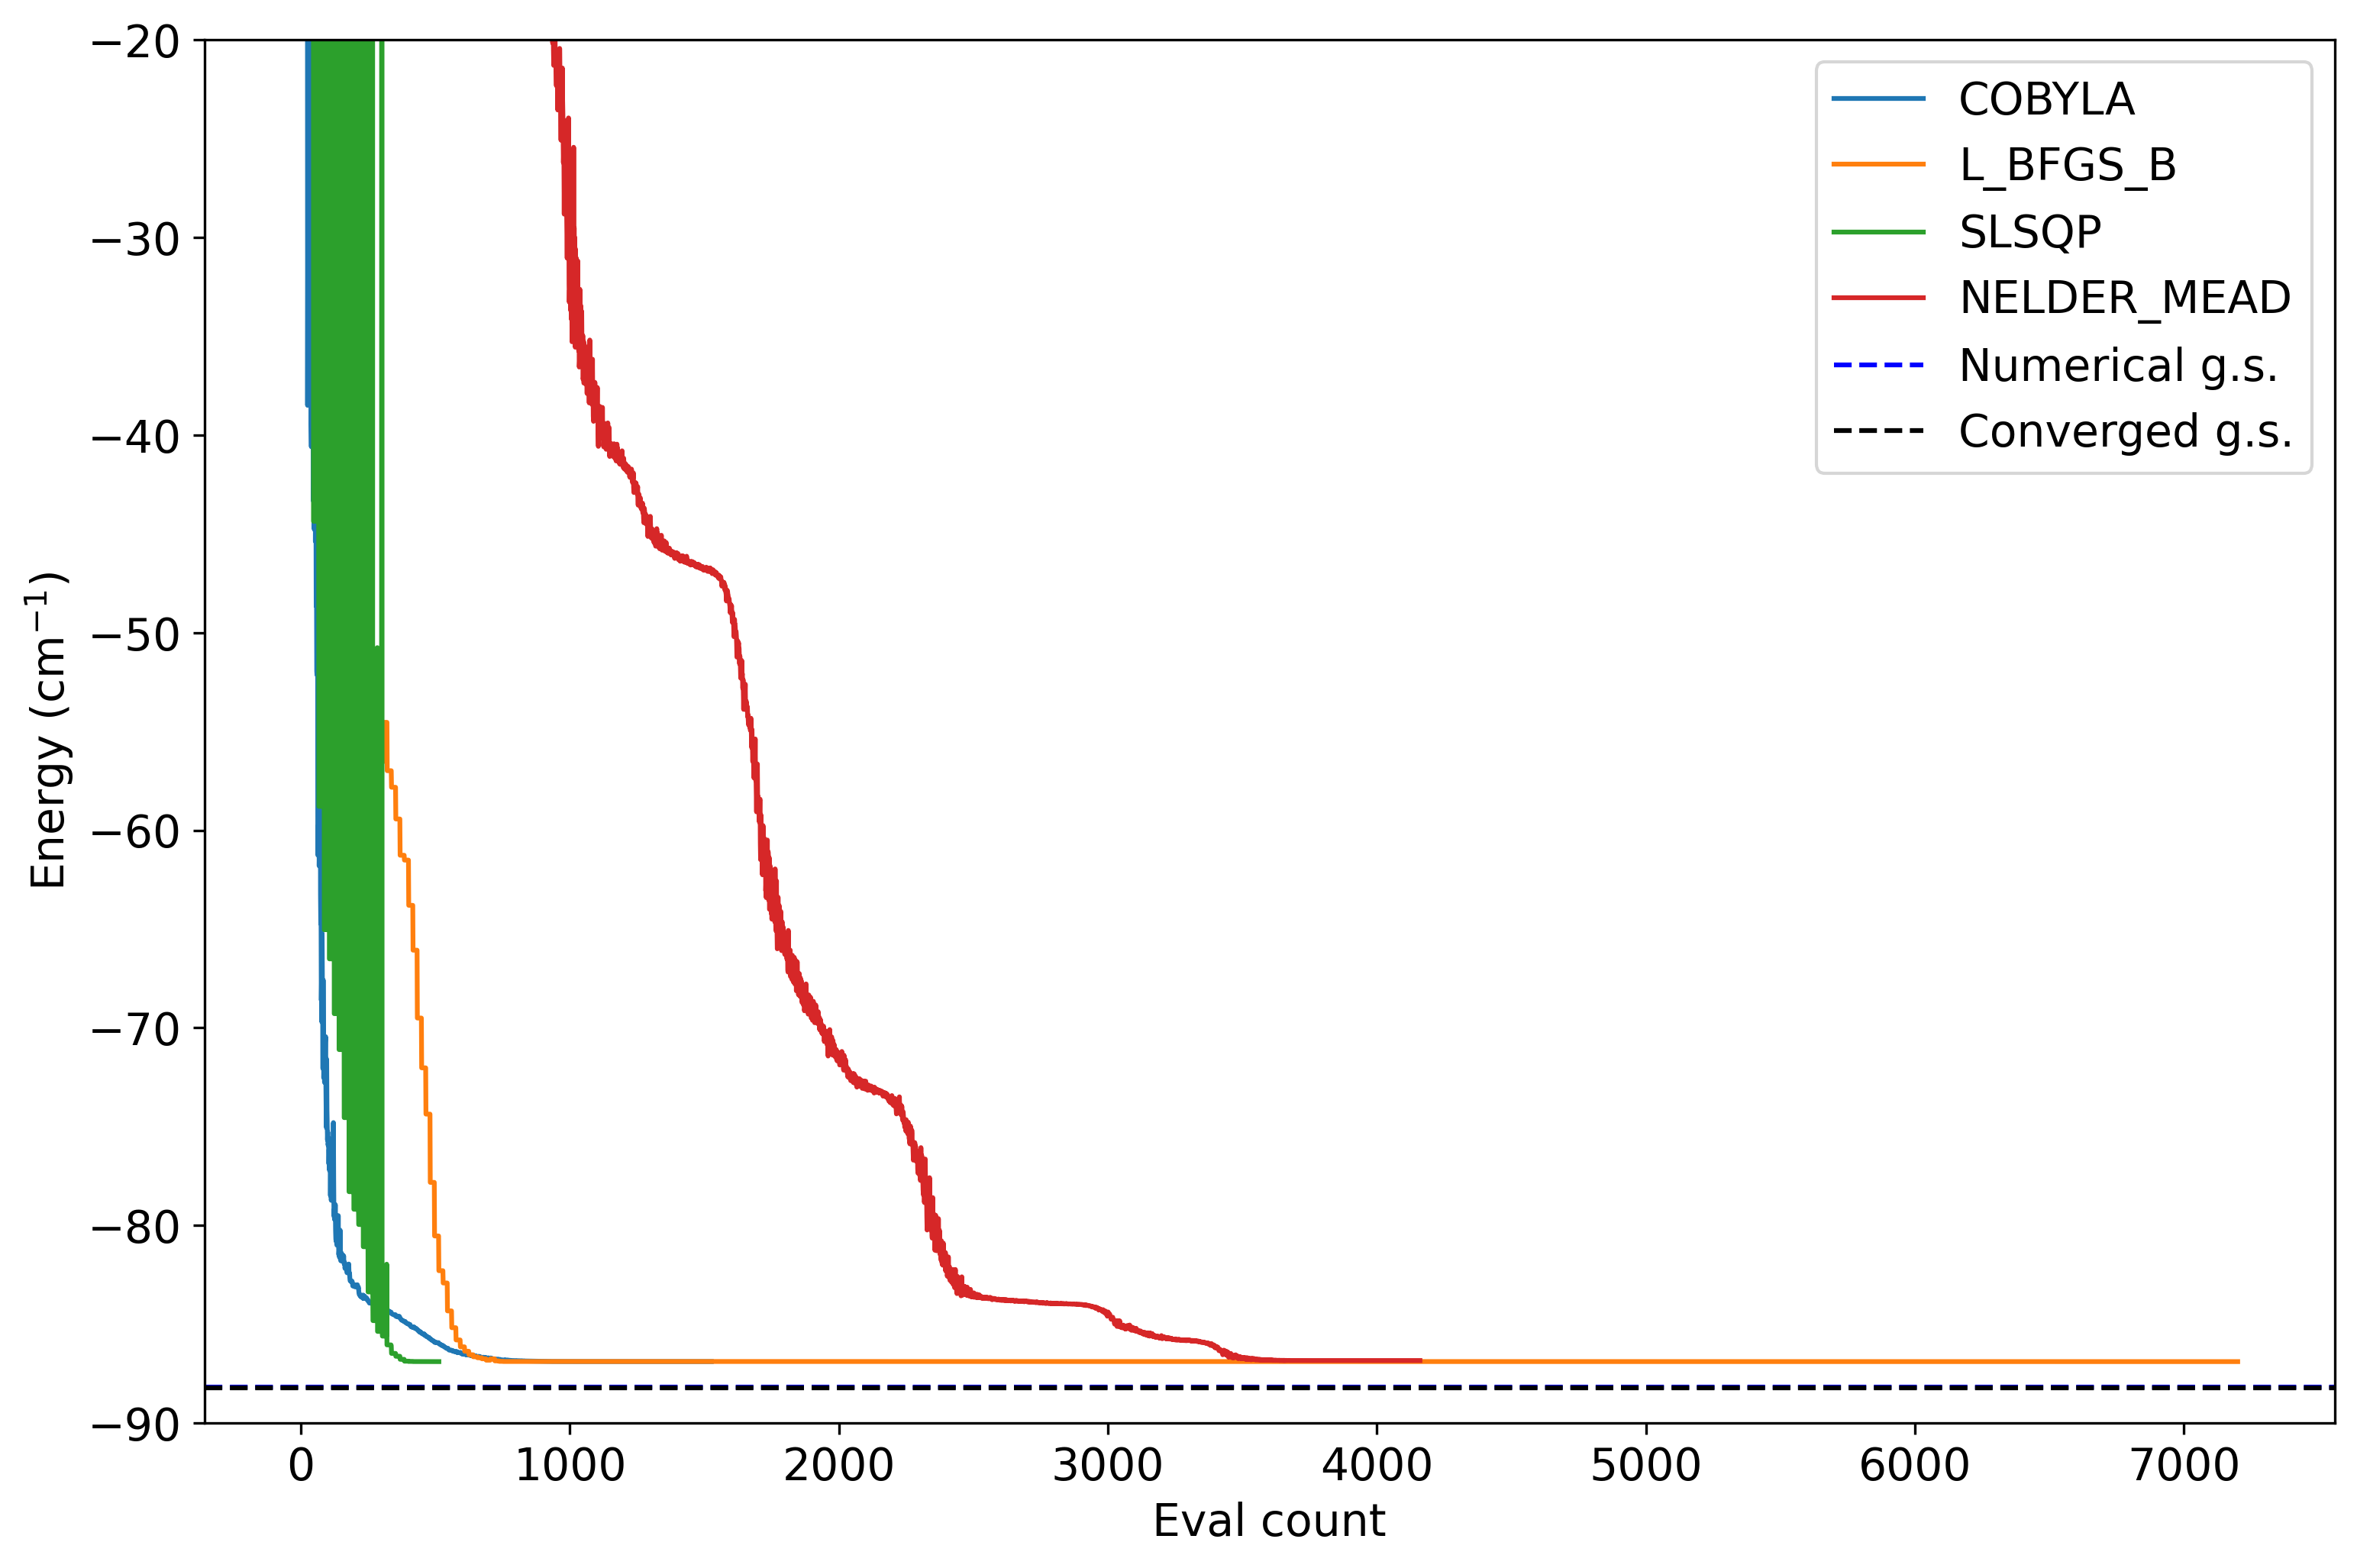

In [76]:
import pylab

ref = -88.22685204564539
# print(converge_cnts1, converge_vals1)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals1[i][-1], abs(ref - converge_vals1[i][-1]))
    pylab.plot(converge_cnts1[i], converge_vals1[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-90, -20)
pylab.legend(loc='upper right');

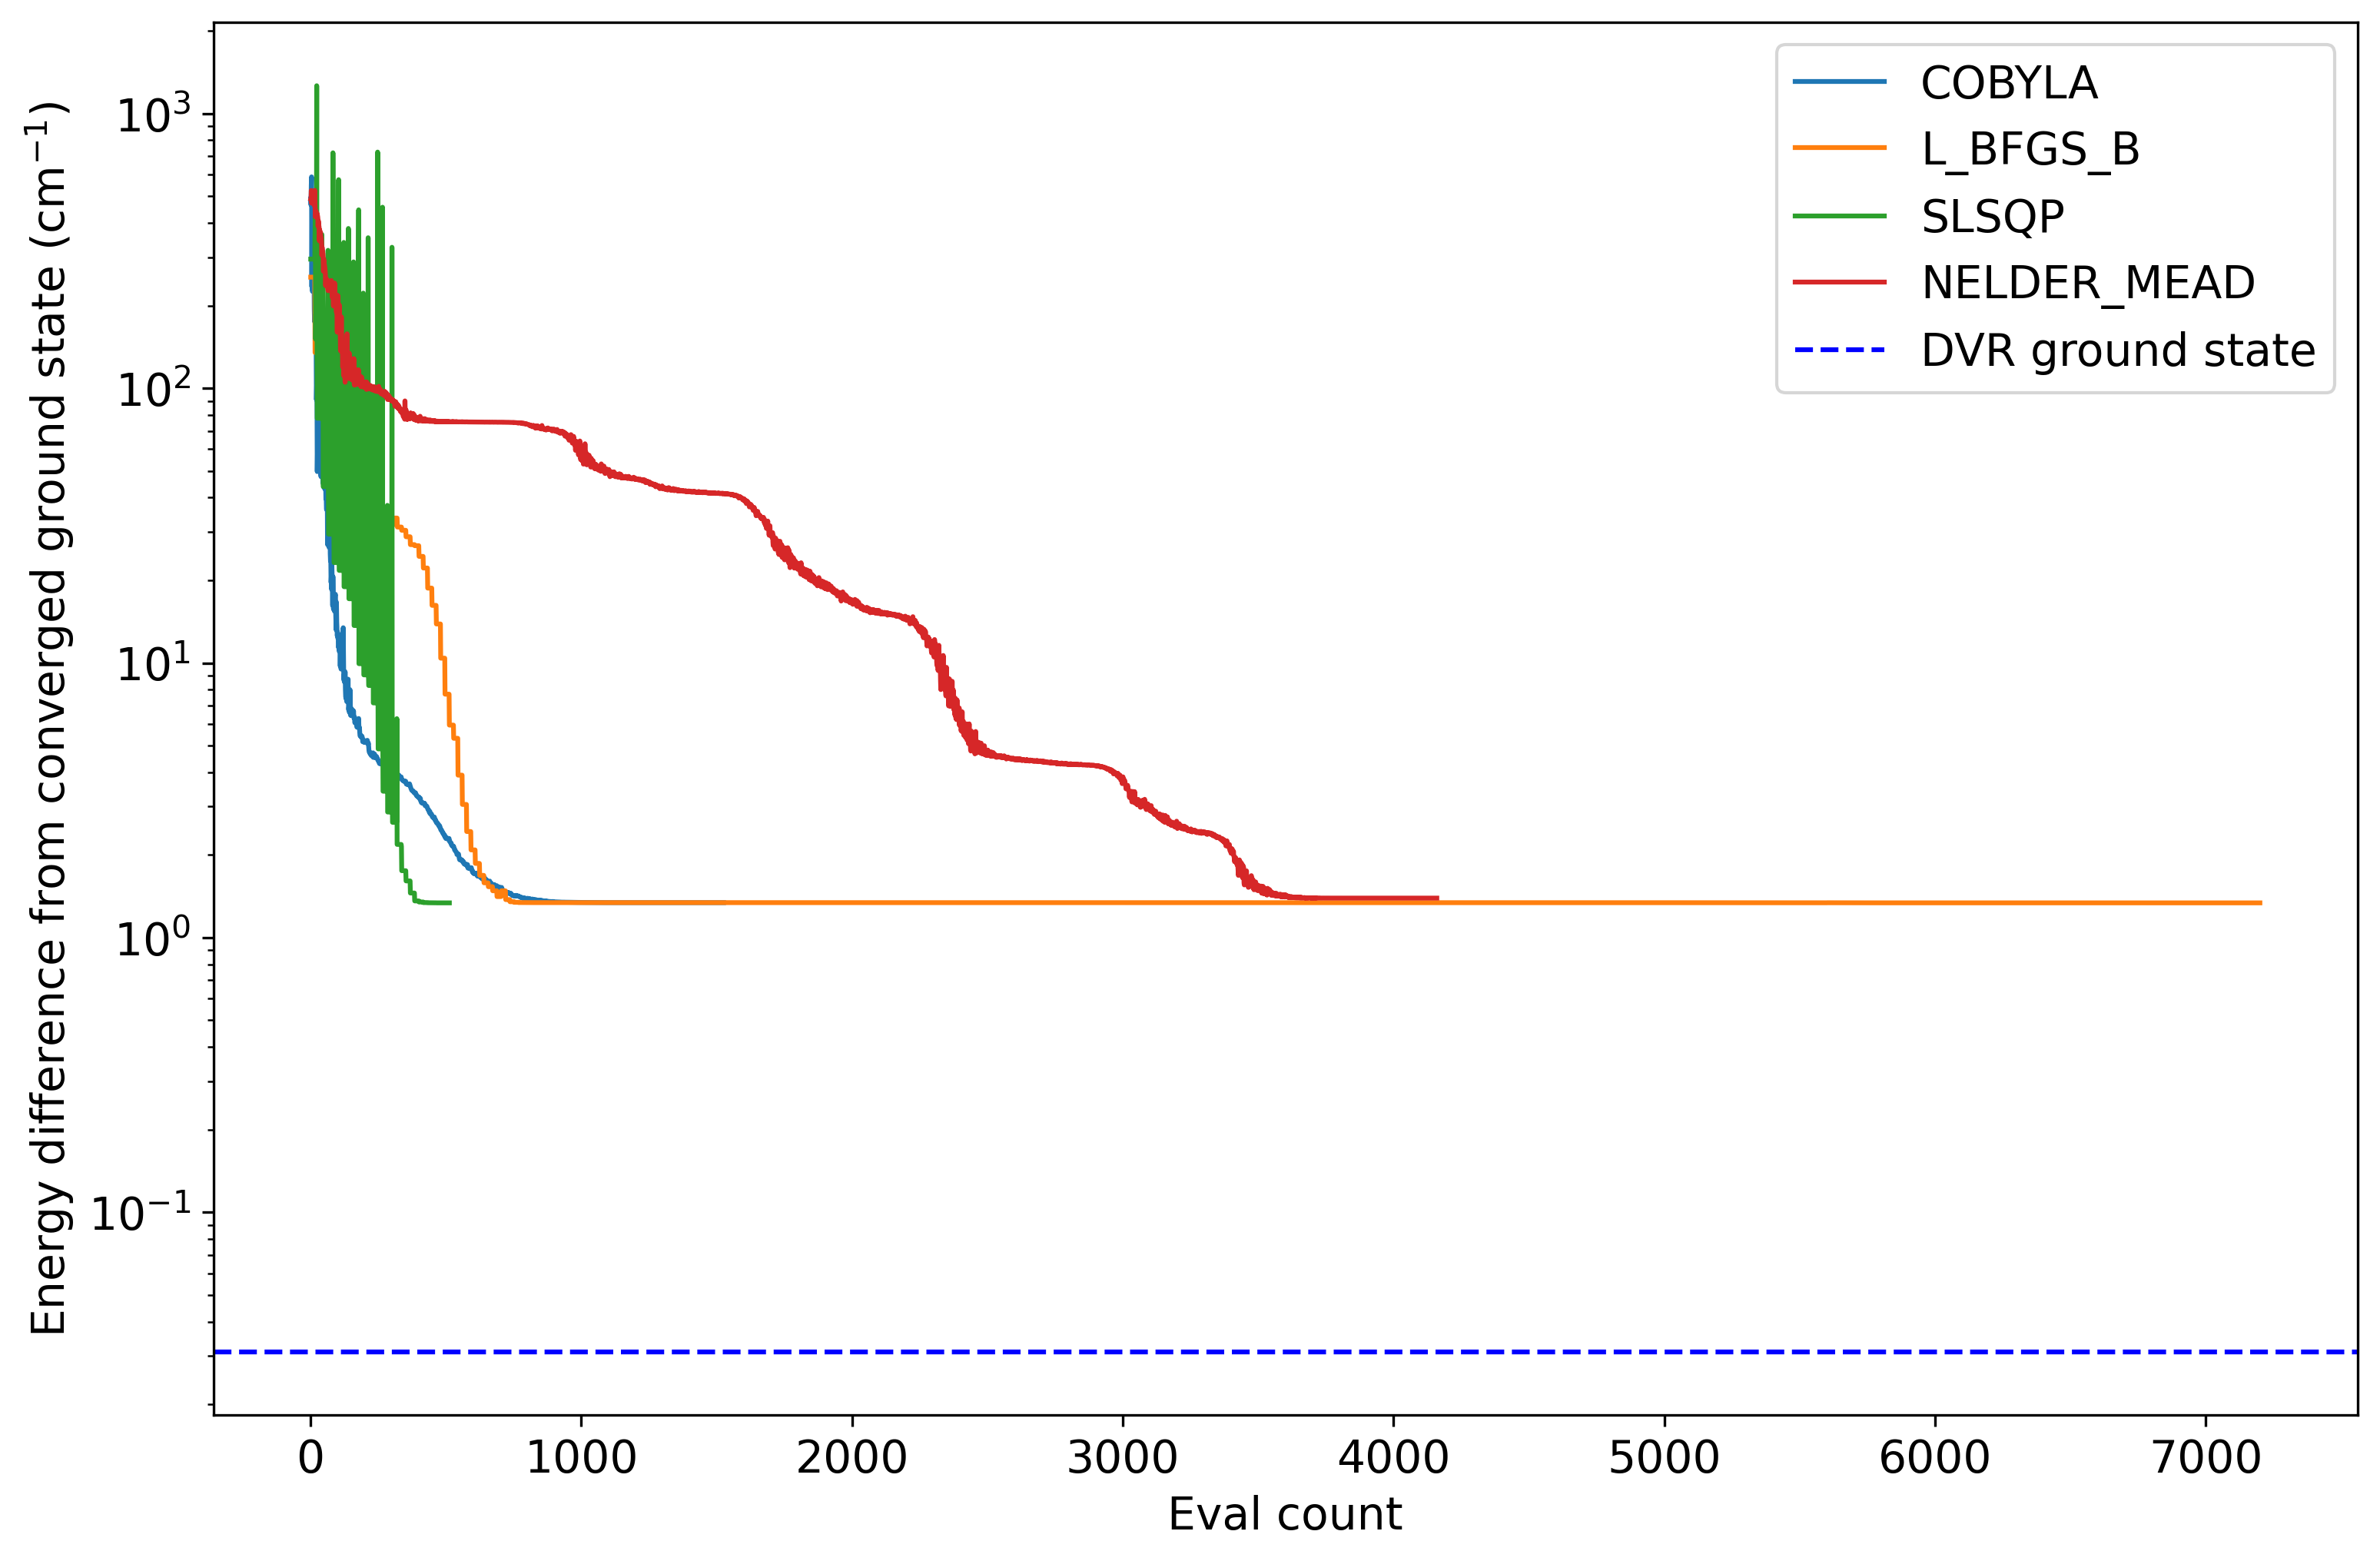

In [77]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

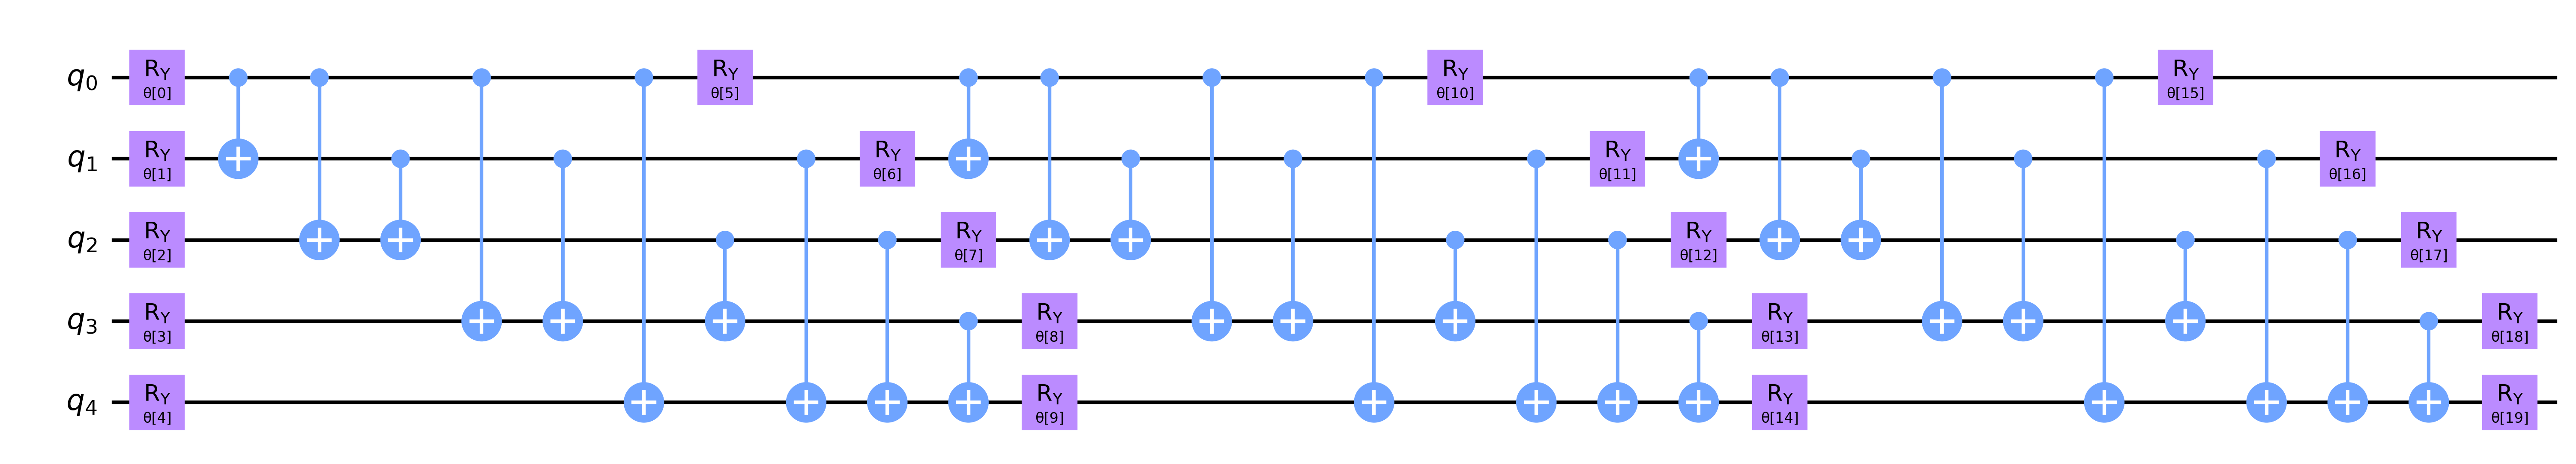

In [80]:
ansatz2 = TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks='cx', entanglement='full', reps=3).decompose()
print(ansatz2.depth())
ansatz2.draw(output='mpl', fold=-1)
# print(ansatz)

In [81]:
# optimizers = [SLSQP(maxiter=1000)]
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts2 = np.empty([len(optimizers)], dtype=object)
converge_vals2 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res2 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz2, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res2 is None) or (values[-1] < best_res2):
            best_res2 = values[-1]
            converge_cnts2[i] = np.asarray(counts)
            converge_vals2[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
8000, -87.68957073792485
8000, -87.64286652375951
8000, -87.96247260620295
Optimizer: L_BFGS_B        
8001, -87.99604563559589
8001, -87.83878512411933
8022, -87.964895603543624
Optimizer: SLSQP        
4937, -87.83765588851207
4516, -88.03829960869325
1425, -87.96557002419867
Optimizer: NELDER_MEAD        
8000, -85.965866643231584
8000, -83.526718951434966
8000, -85.6679145973164254

Optimization complete      


COBYLA -87.96247260620295 0.26437943944243614
L_BFGS_B -87.99604563559589 0.23080641004949598
SLSQP -88.03829960869325 0.1885524369521363
NELDER_MEAD -85.96586664323158 2.2609854024138087
0.031053018200125848


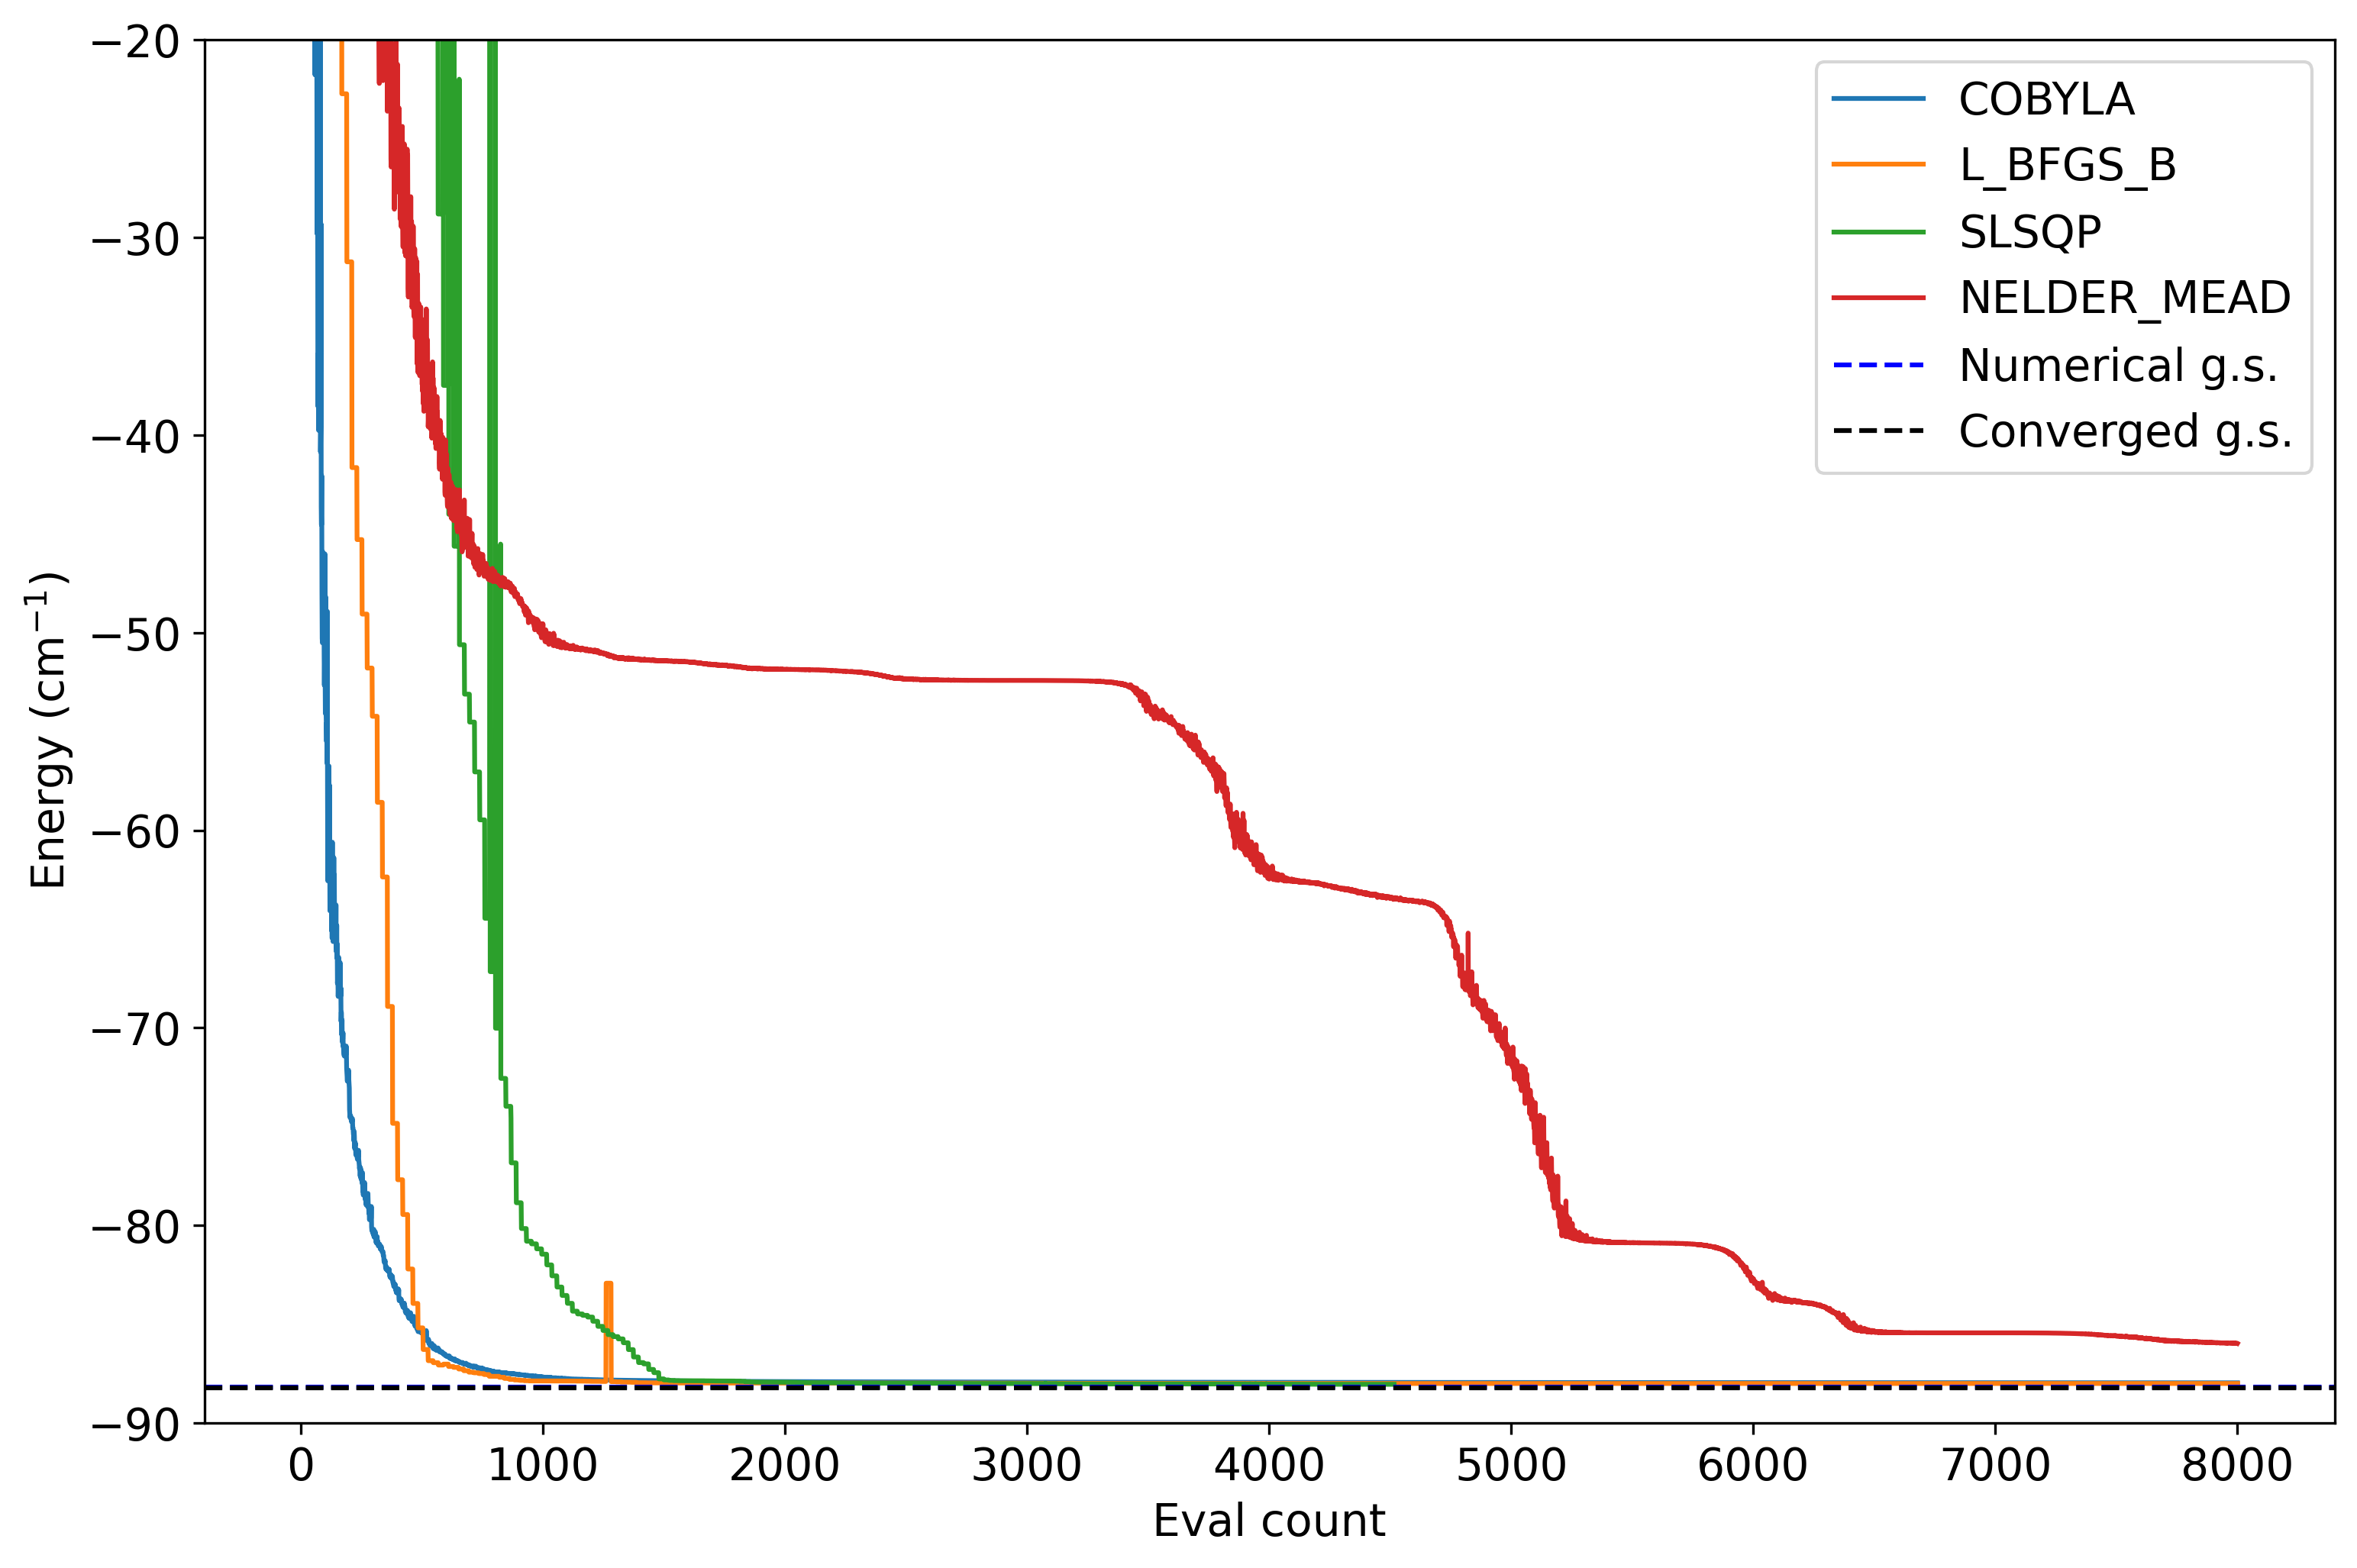

In [82]:
import pylab

ref = -88.22685204564539
# print(converge_cnts2, converge_vals2)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals2[i][-1], abs(ref - converge_vals2[i][-1]))
    pylab.plot(converge_cnts2[i], converge_vals2[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-90, -20)
pylab.legend(loc='upper right');

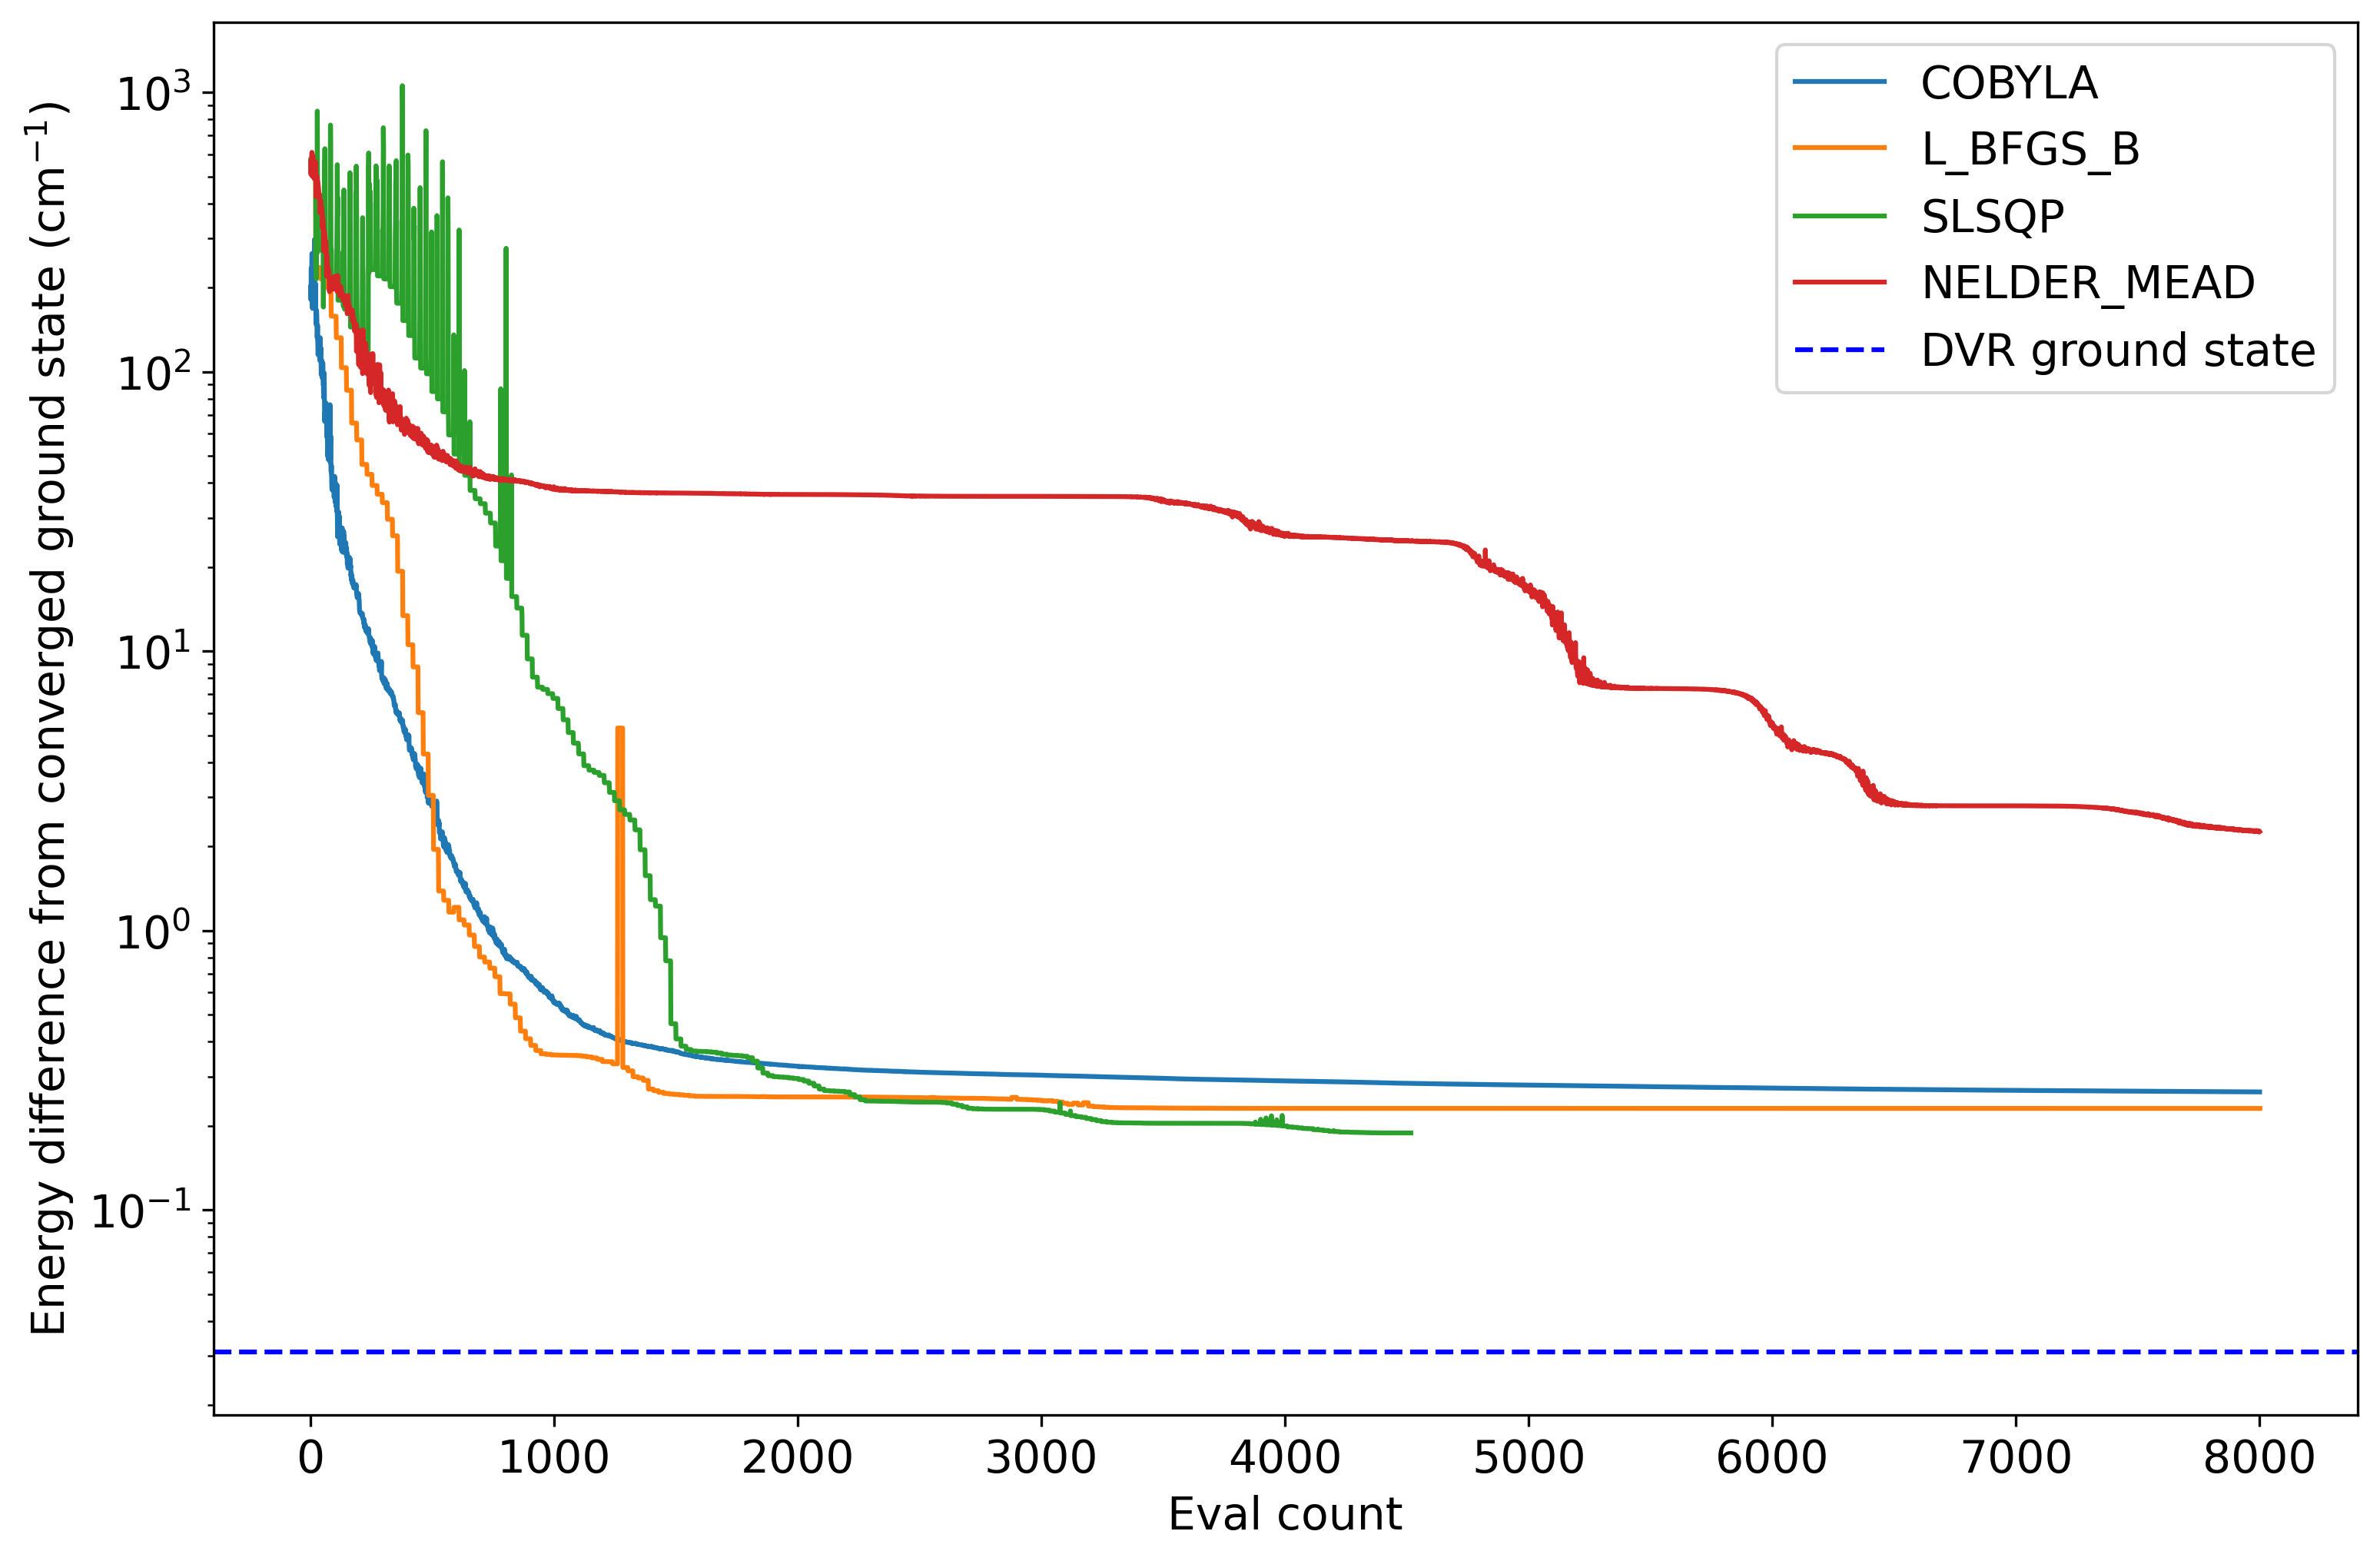

In [83]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts2[i][:], abs(ref - converge_vals2[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

9


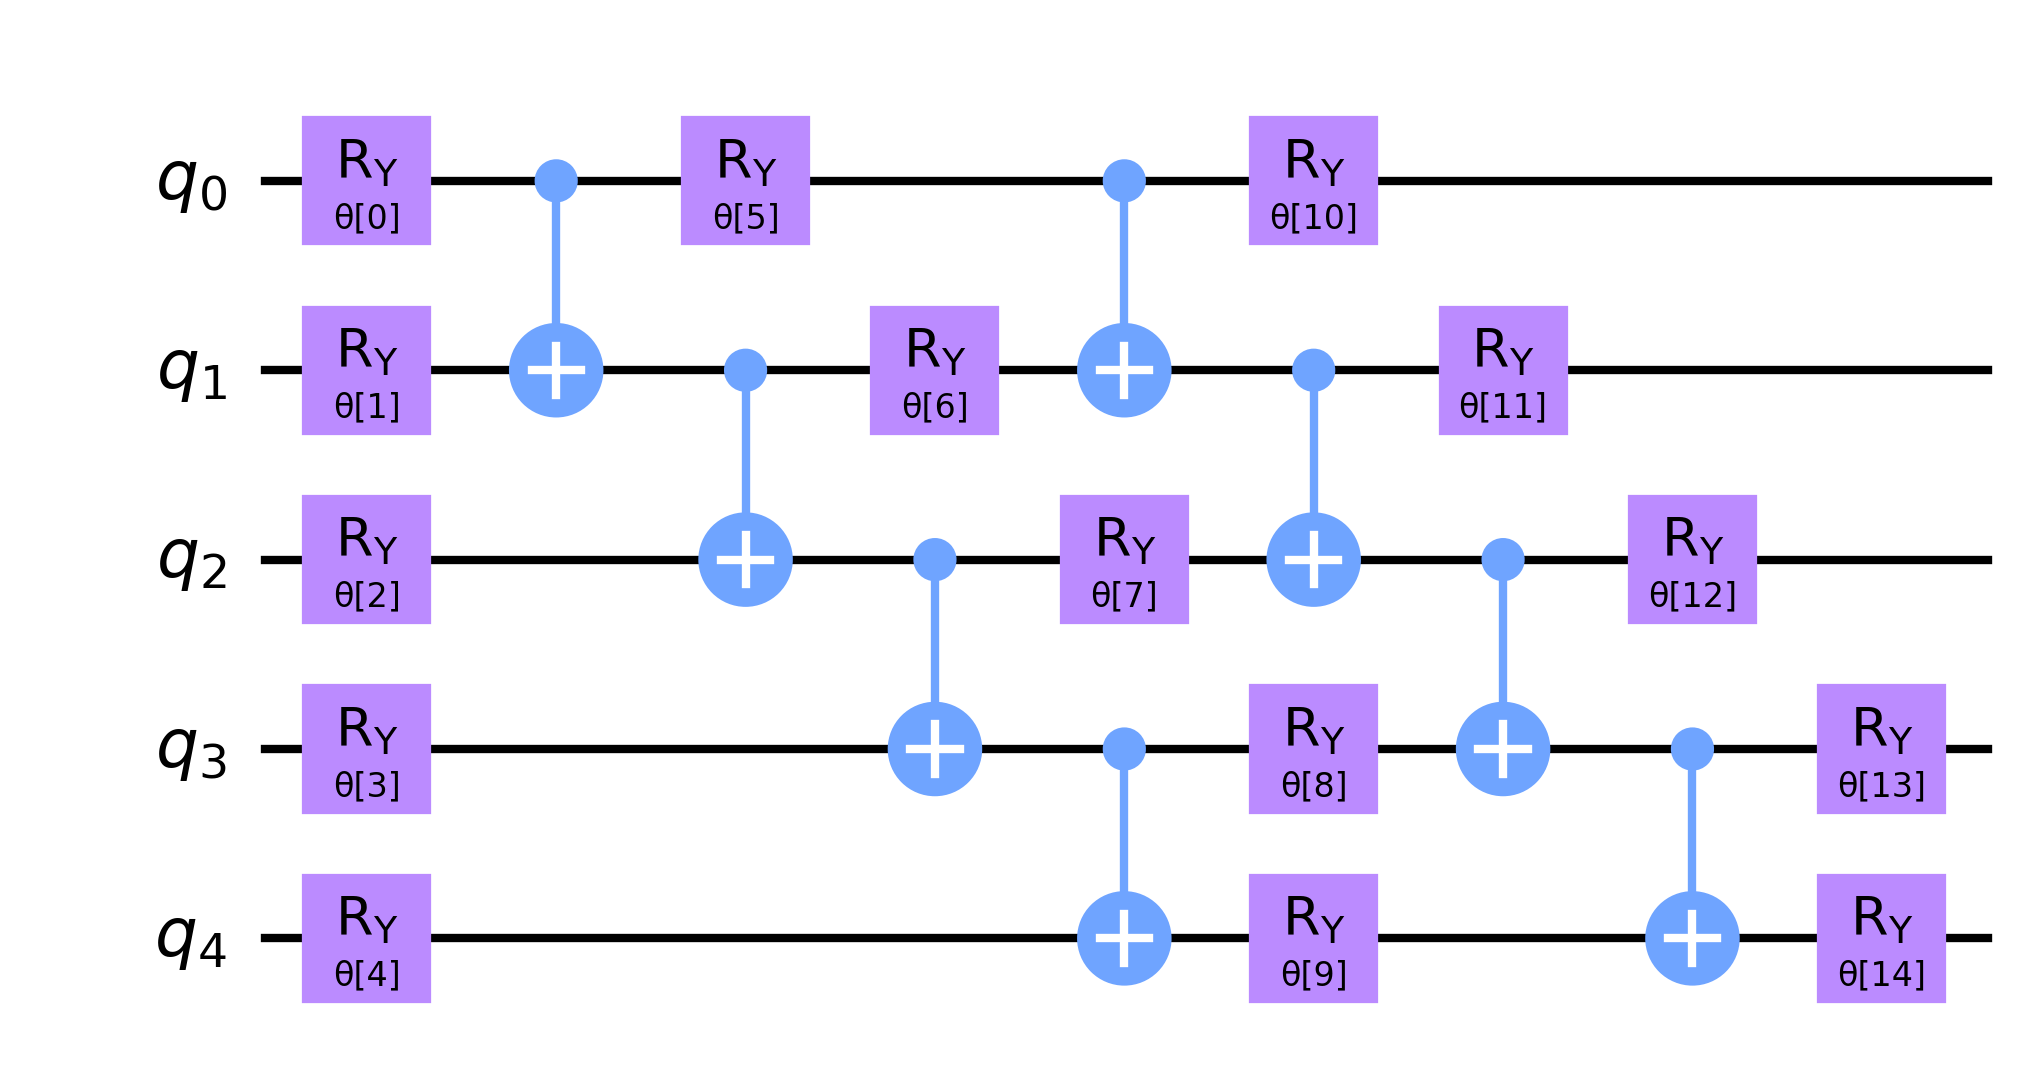

In [92]:
ansatz3 = TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks='cx', entanglement='linear', reps=2).decompose()
print(ansatz3.depth())
ansatz3.draw(output='mpl', fold=-1)

In [93]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts3 = np.empty([len(optimizers)], dtype=object)
converge_vals3 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res3 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz3, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res3 is None) or (values[-1] < best_res3):
            best_res3 = values[-1]
            converge_cnts3[i] = np.asarray(counts)
            converge_vals3[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
2767, -87.86892155748142
2629, -87.876071975792466
8000, -79.59094244065628
Optimizer: L_BFGS_B        
3632, -87.87632031188178
2560, -87.87632031259525
6368, -87.87629440968162
Optimizer: SLSQP        
1137, -87.87616831180182
803, -87.876130625349894
959, -87.869042208994646
Optimizer: NELDER_MEAD        
4901, -87.876134267297926
8000, -87.87122037866722
6566, -80.522313788028926

Optimization complete      


COBYLA -87.87607197579246 0.35078006985293086
L_BFGS_B -87.87632031259525 0.35053173305013274
SLSQP -87.87616831180182 0.3506837338435673
NELDER_MEAD -87.876134267297 0.3507177783483826
0.031053018200125848


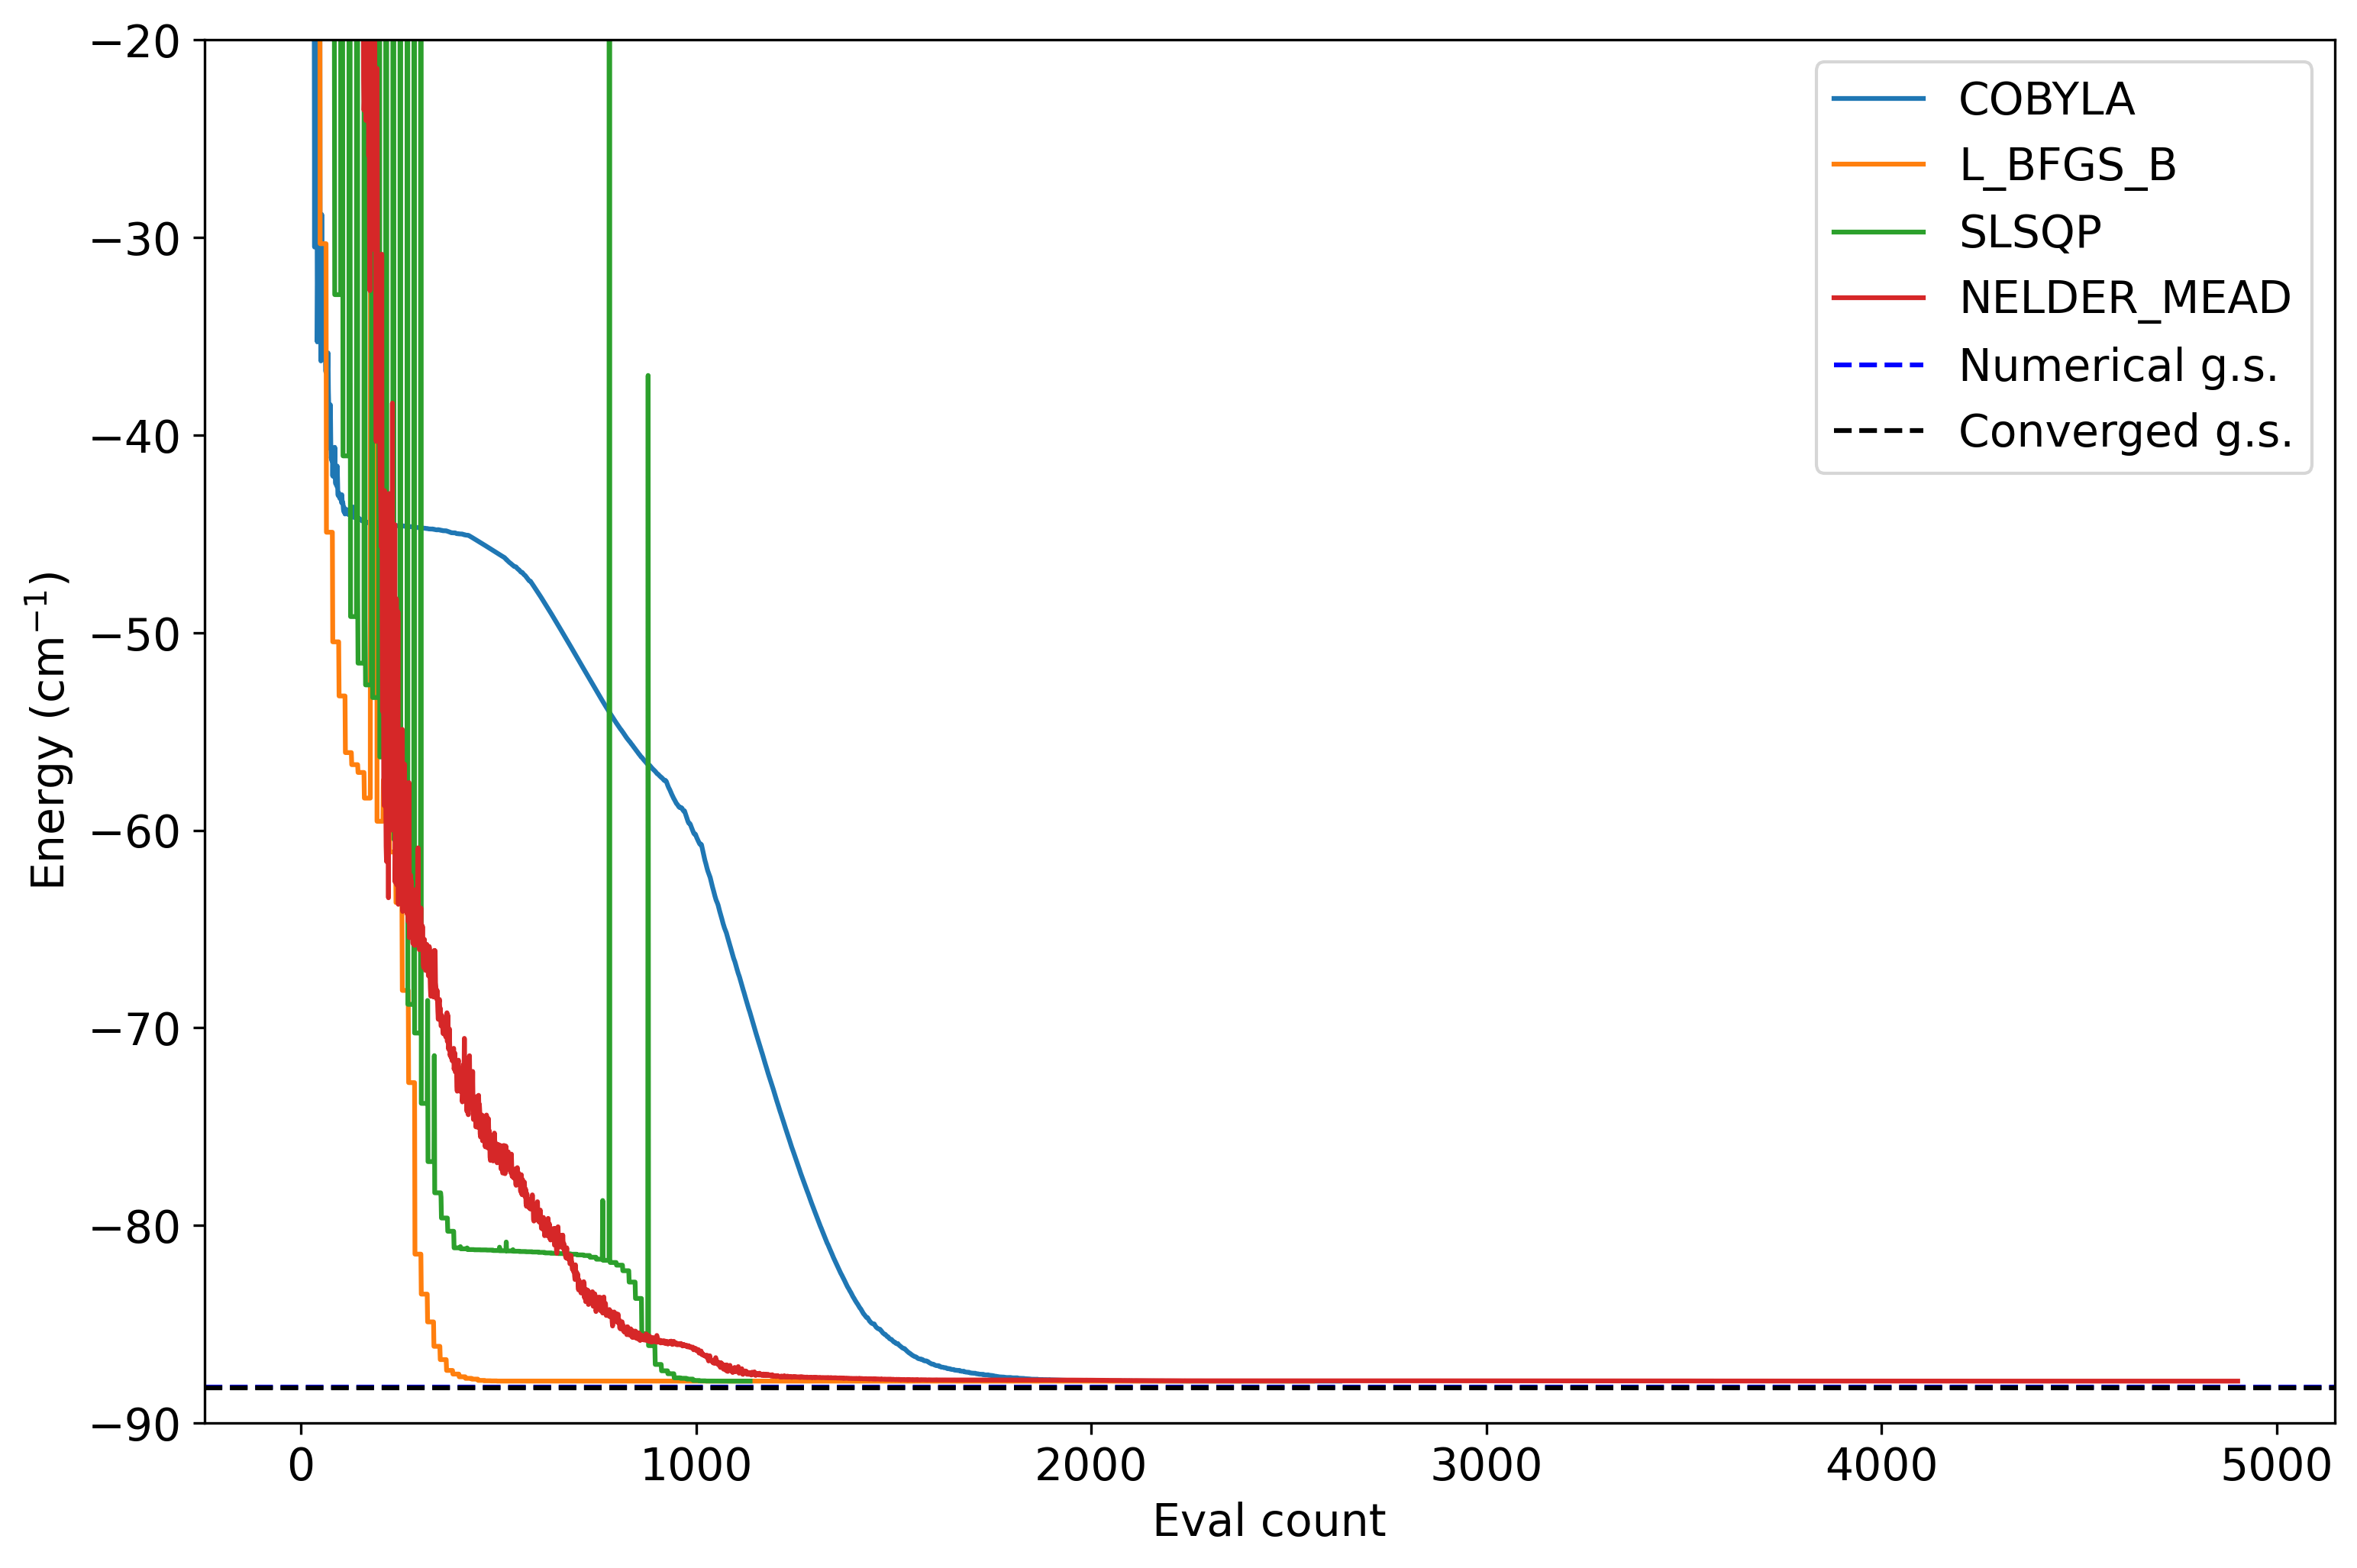

In [95]:
import pylab

ref = -88.22685204564539
# print(converge_cnts2, converge_vals3)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals3[i][-1], abs(ref - converge_vals3[i][-1]))
    pylab.plot(converge_cnts3[i], converge_vals3[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-90, -20)
pylab.legend(loc='upper right');

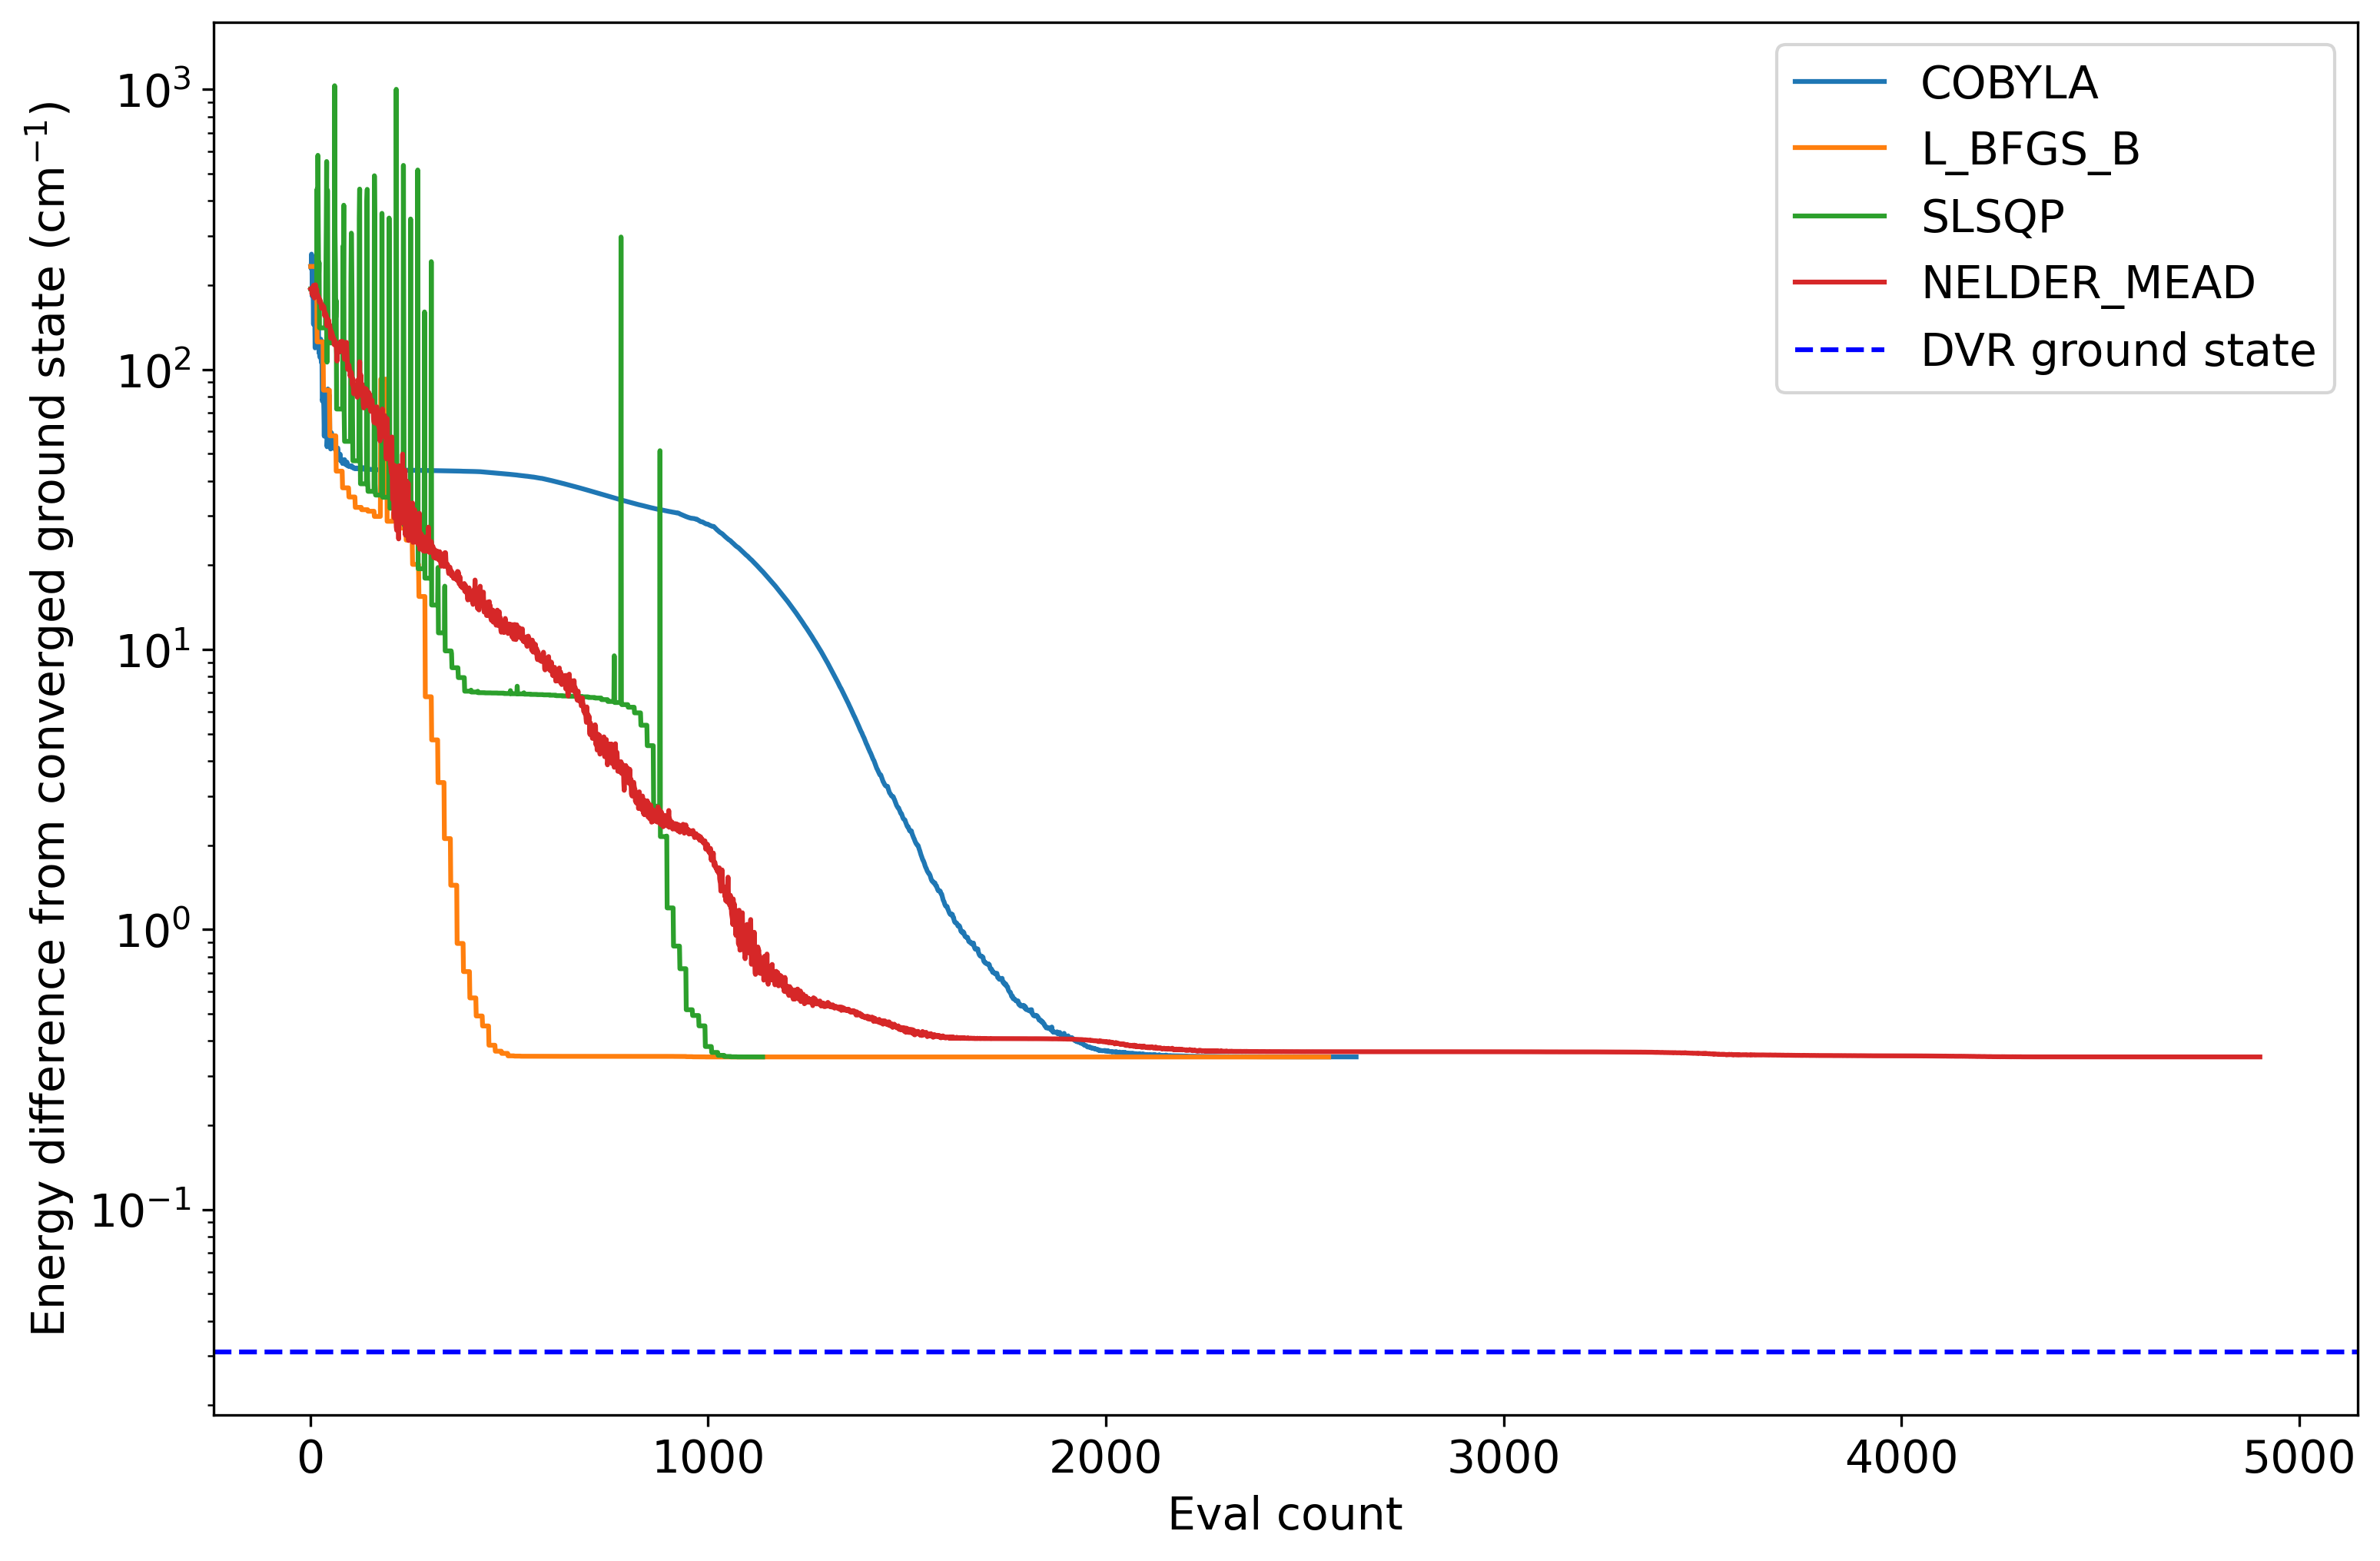

In [96]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts3[i][:], abs(ref - converge_vals3[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

13


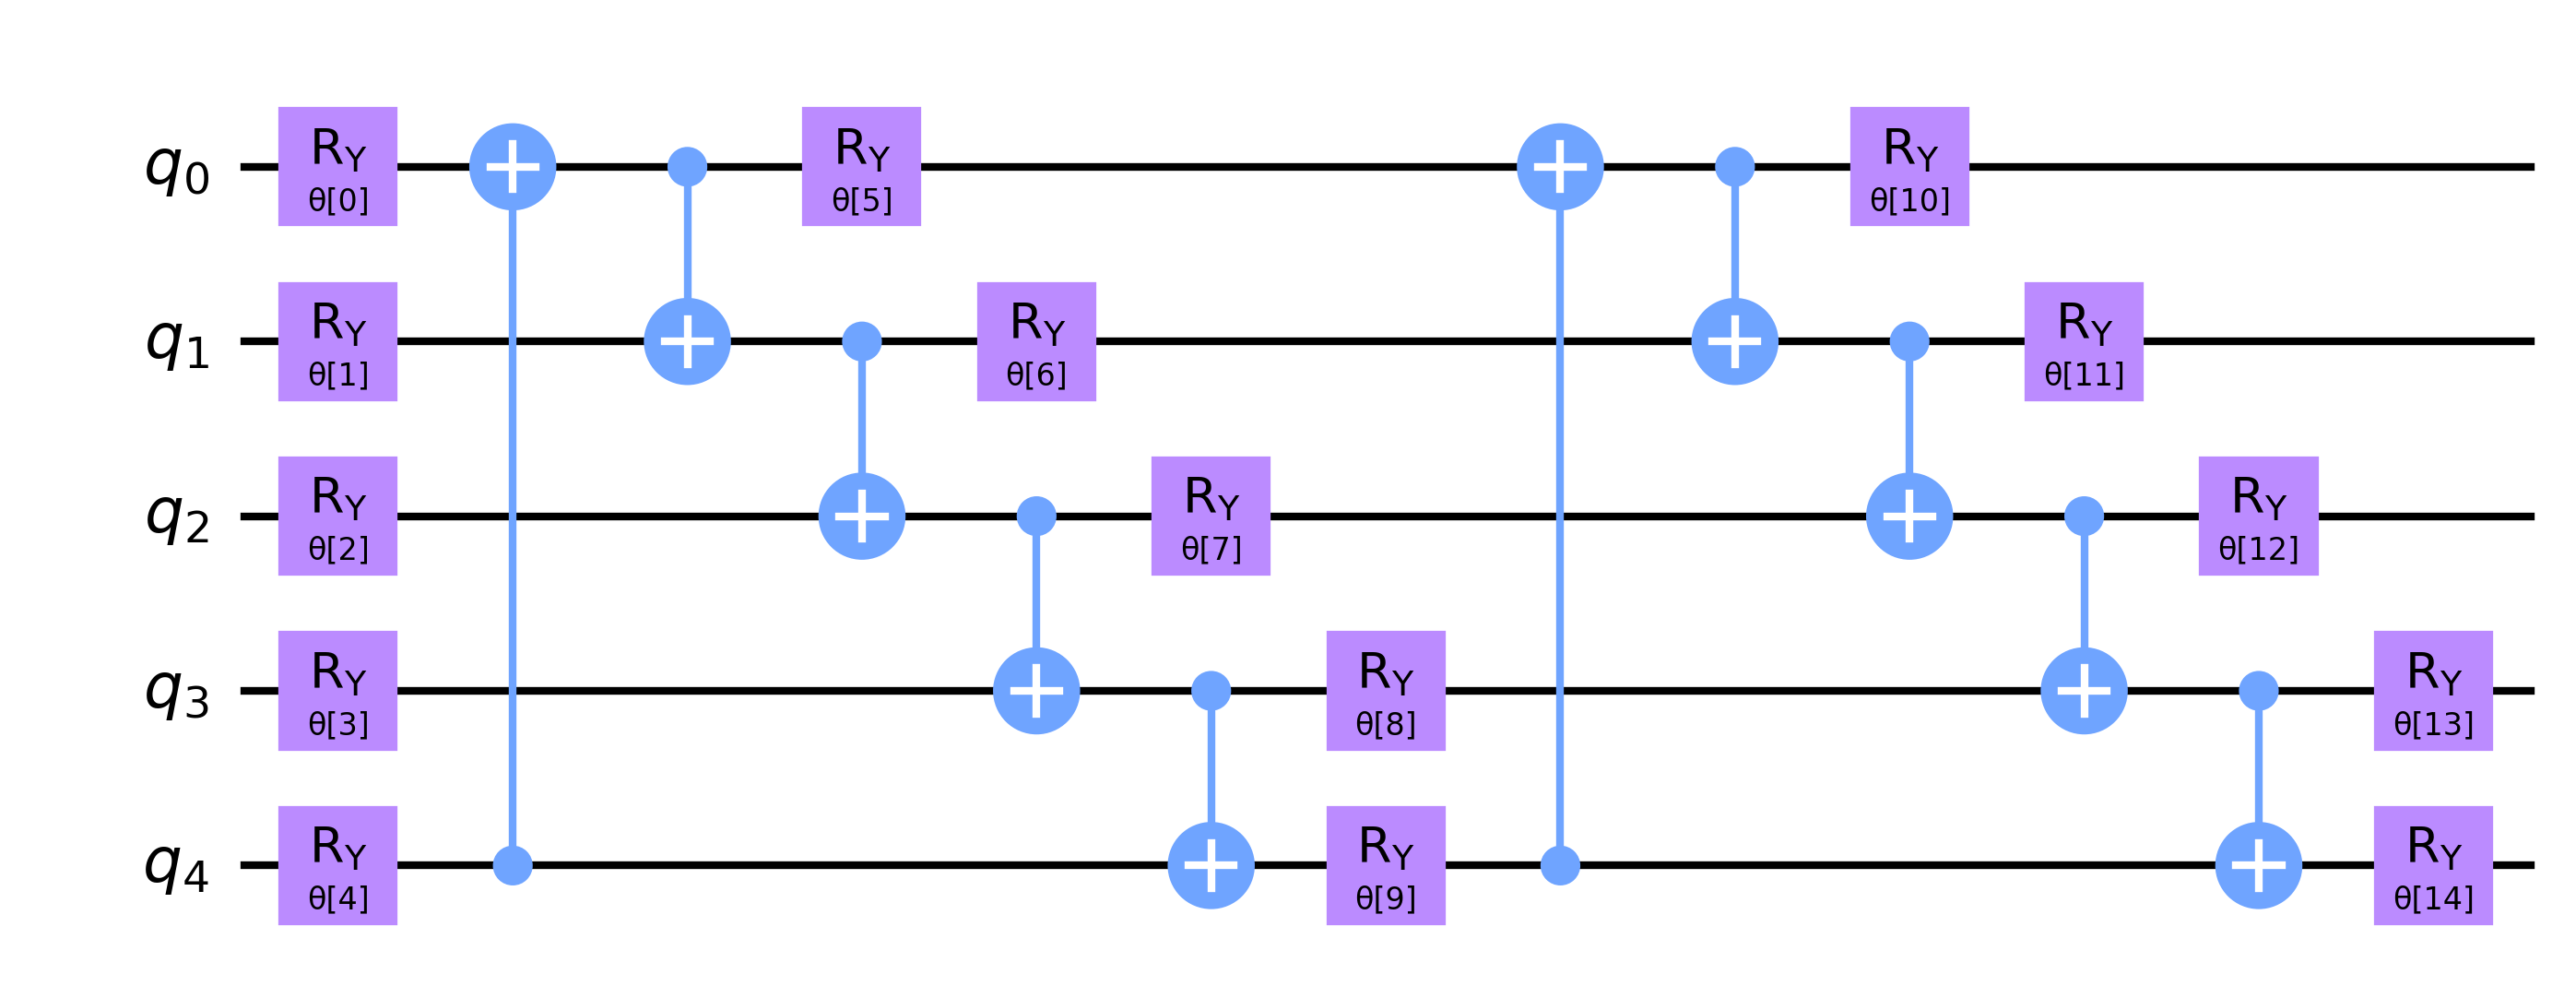

In [100]:
ansatz4 = TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks='cx', entanglement='circular', reps=2).decompose()
print(ansatz4.depth())
ansatz4.draw(output='mpl', fold=-1)

In [101]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts4 = np.empty([len(optimizers)], dtype=object)
converge_vals4 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz1.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res4 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz4, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res4 is None) or (values[-1] < best_res4):
            best_res4 = values[-1]
            converge_cnts4[i] = np.asarray(counts)
            converge_vals4[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
1920, -82.708967806676186
1194, -82.69756716745641
8000, -82.69513824270554
Optimizer: L_BFGS_B        
2432, -79.73839974987202
4624, -79.724556090742184
960, -82.697571831819226
Optimizer: SLSQP        
1761, -79.72455579086294
930, -81.635703321380655
938, -81.635703078335586
Optimizer: NELDER_MEAD        
7651, -80.565582028240984
4996, -66.781057195732445
8000, -77.172739750064954

Optimization complete      


COBYLA -77.71944209164707 10.50740995399832
L_BFGS_B -77.71944429346861 10.507407752176775
SLSQP -77.71944428288592 10.50740776275947
NELDER_MEAD -77.71944428666586 10.507407758979525
0.031053018200125848


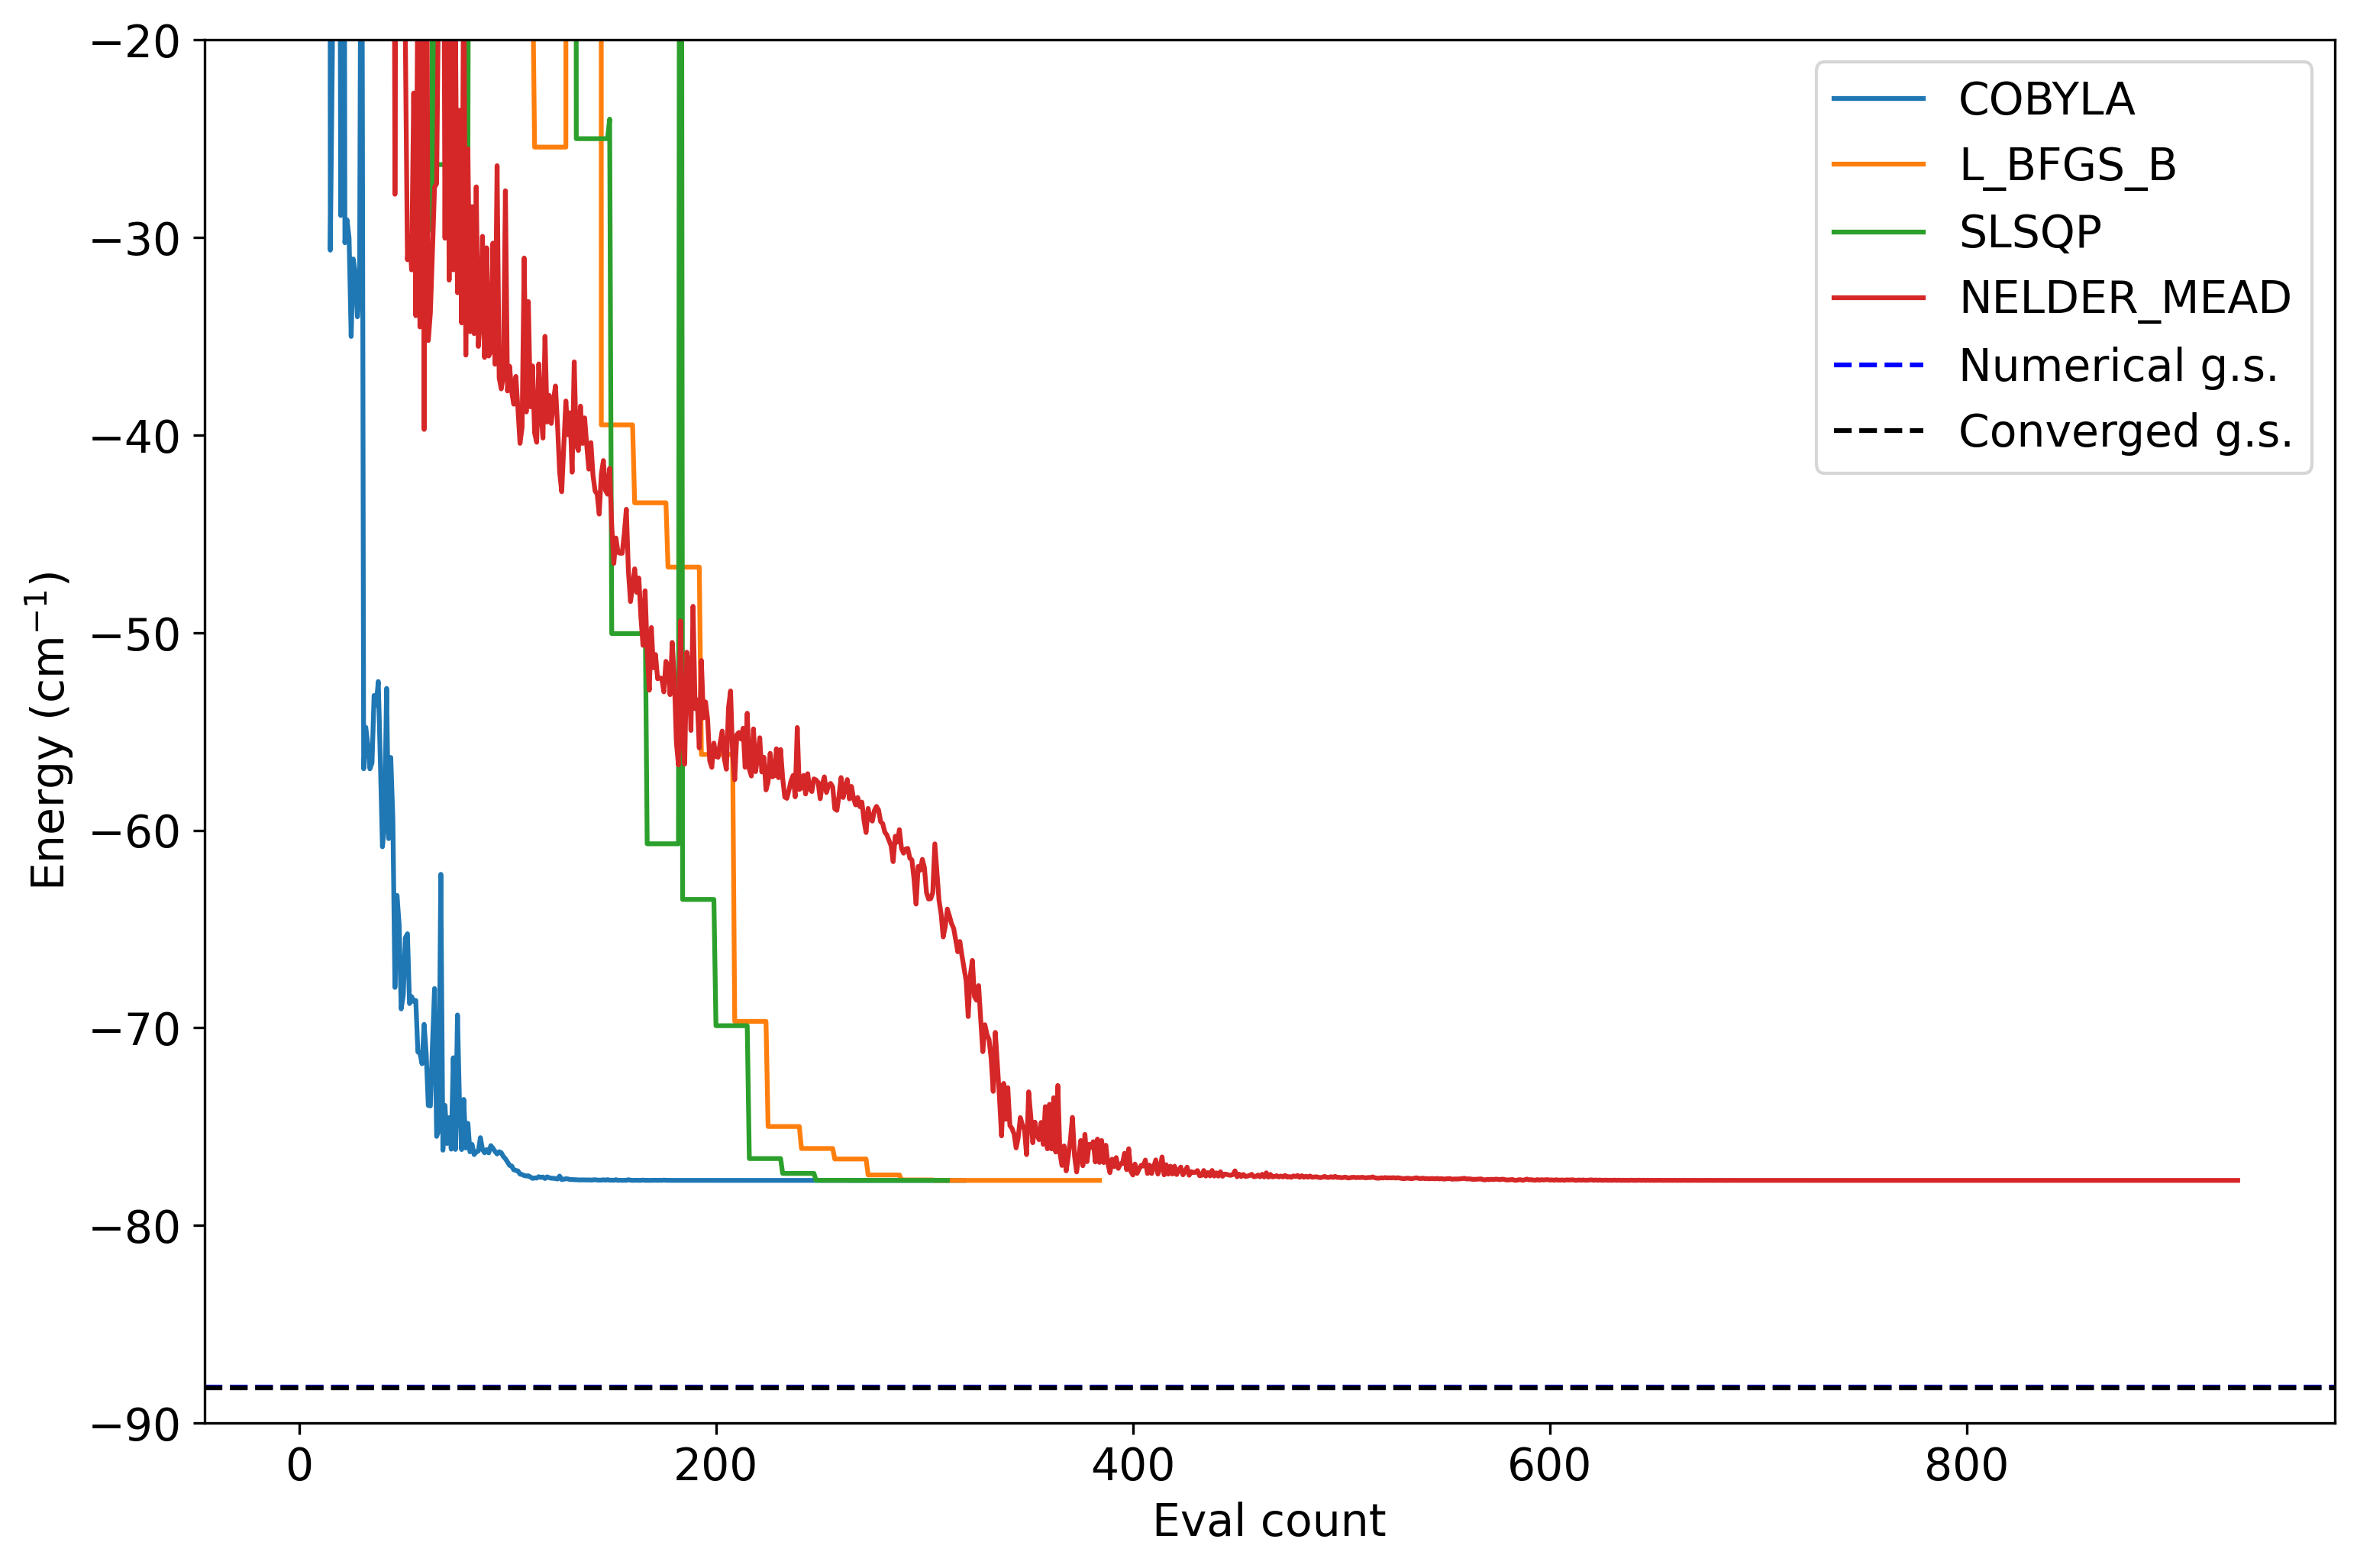

In [102]:
import pylab

ref = -88.22685204564539
# print(converge_cnts2, converge_vals3)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals3[i][-1], abs(ref - converge_vals3[i][-1]))
    pylab.plot(converge_cnts3[i], converge_vals3[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-90, -20)
pylab.legend(loc='upper right');

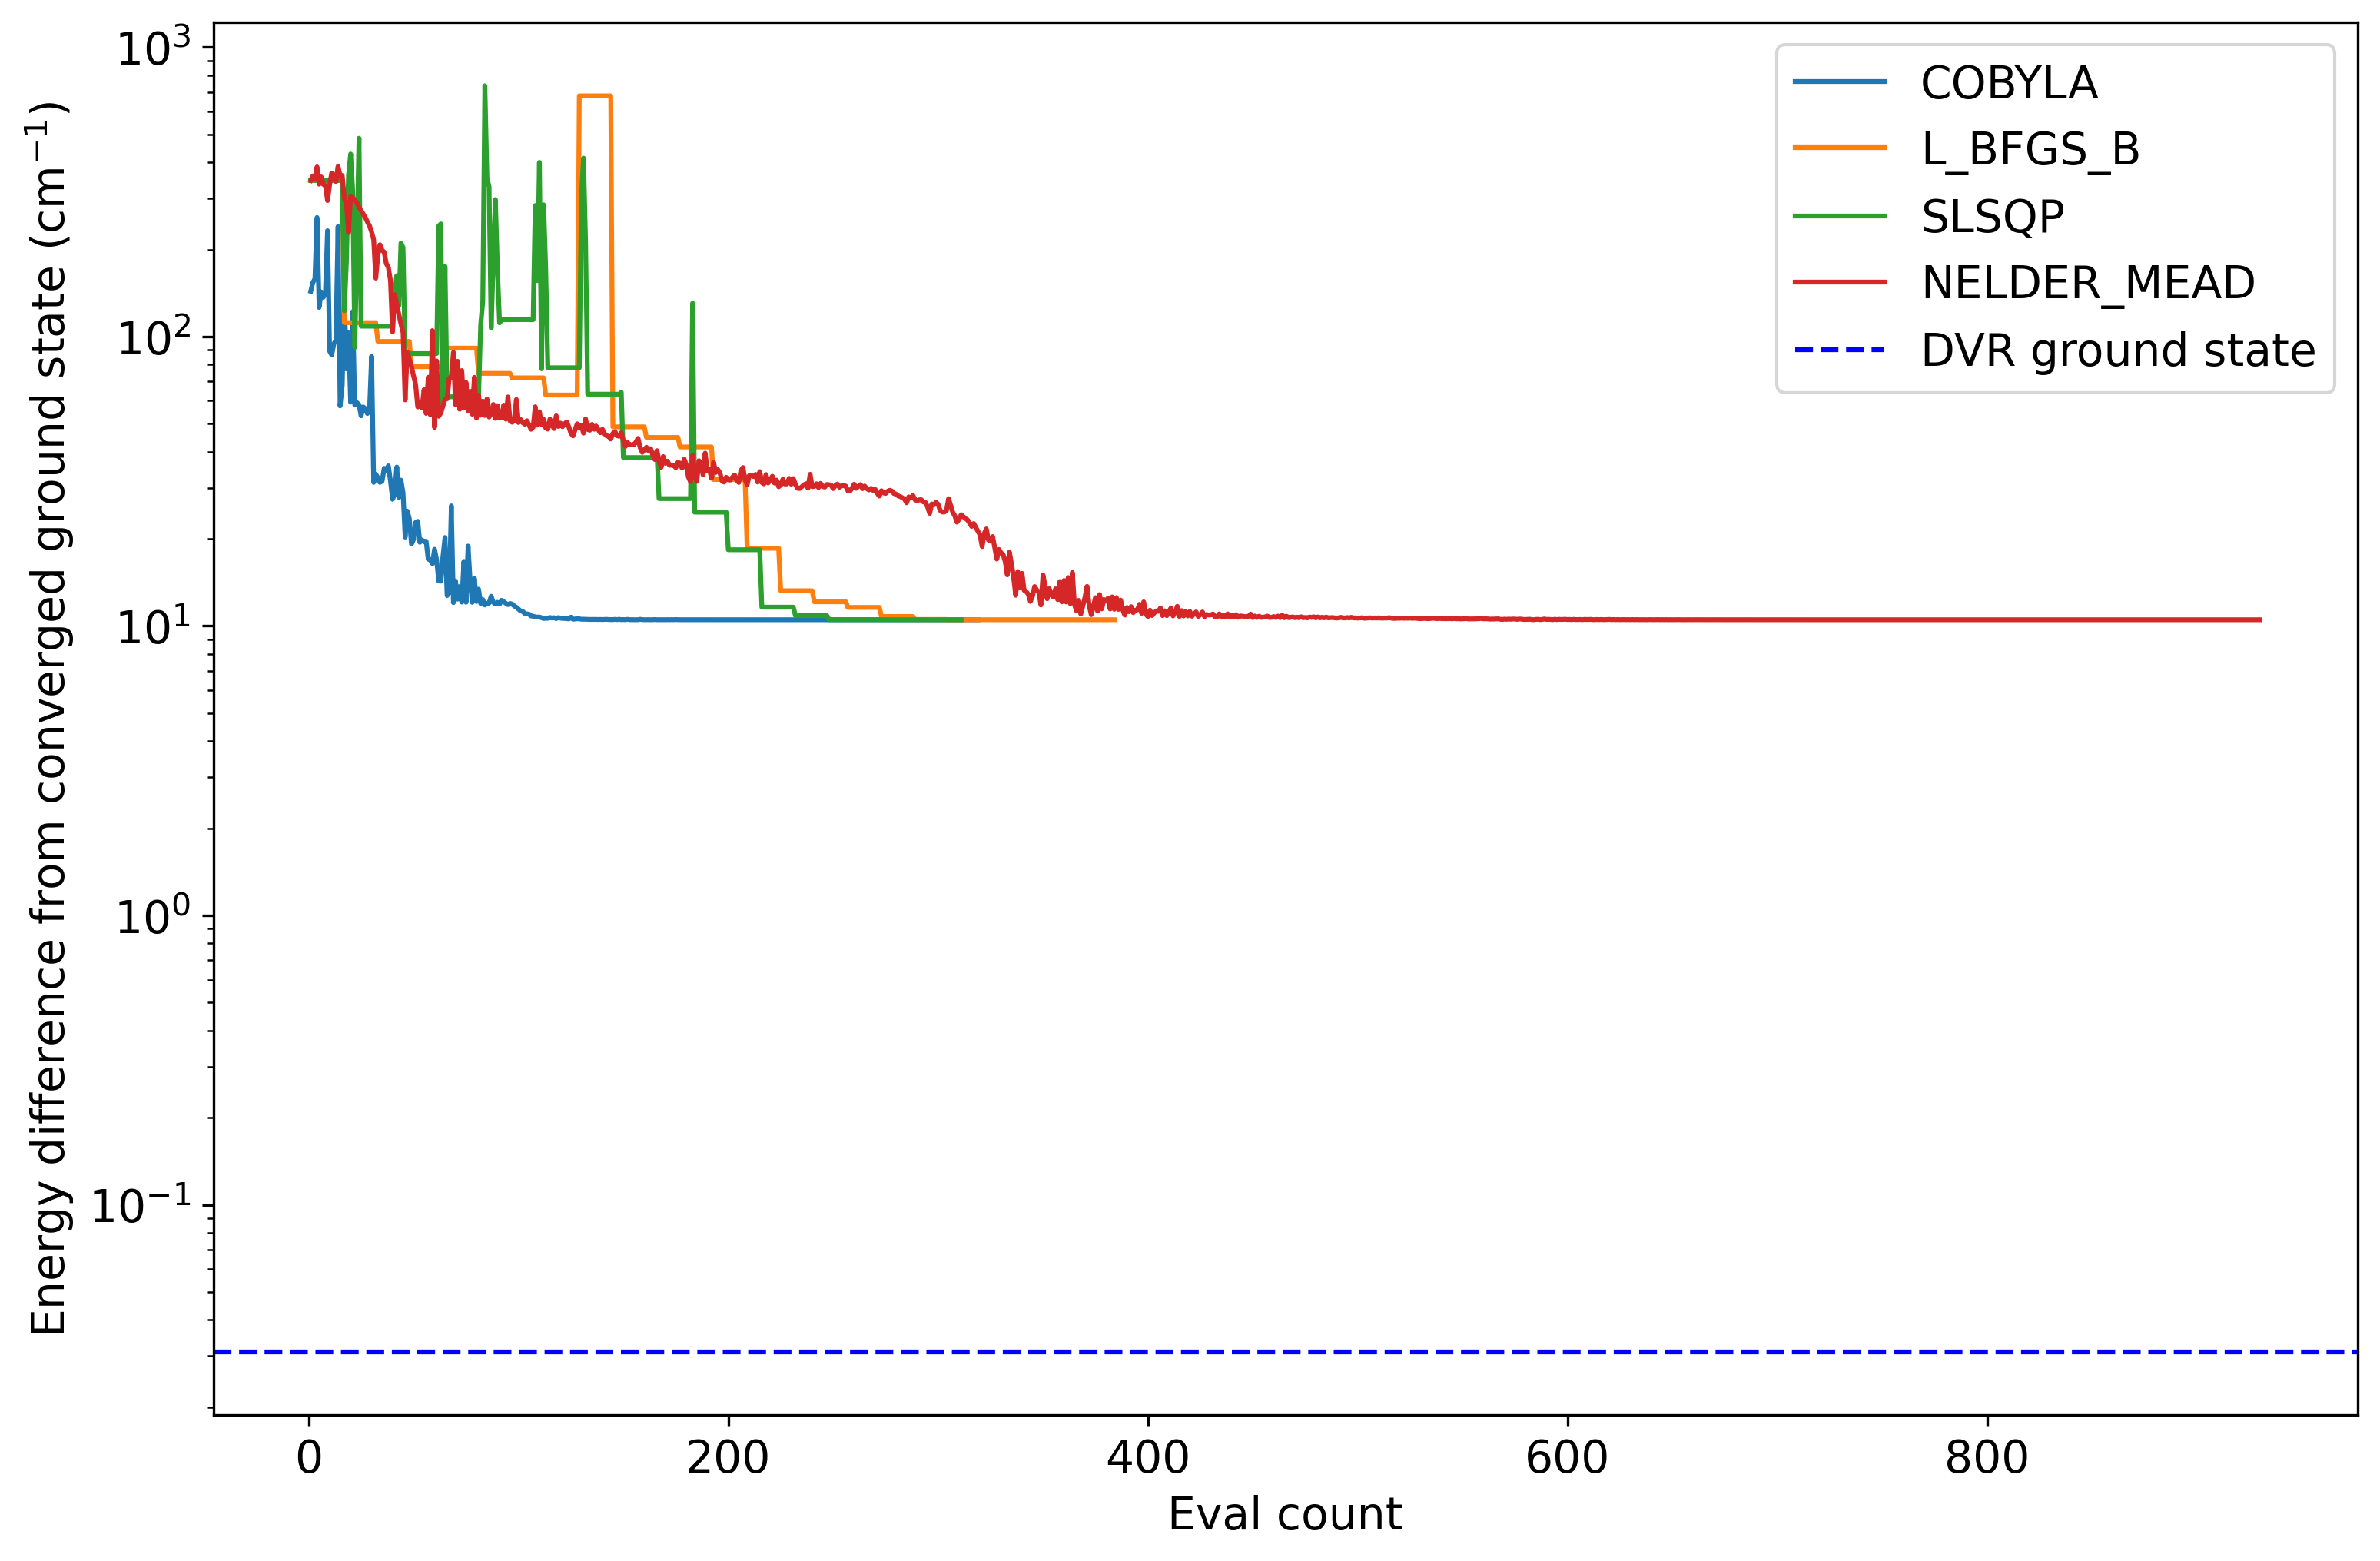

In [103]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts3[i][:], abs(ref - converge_vals3[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))

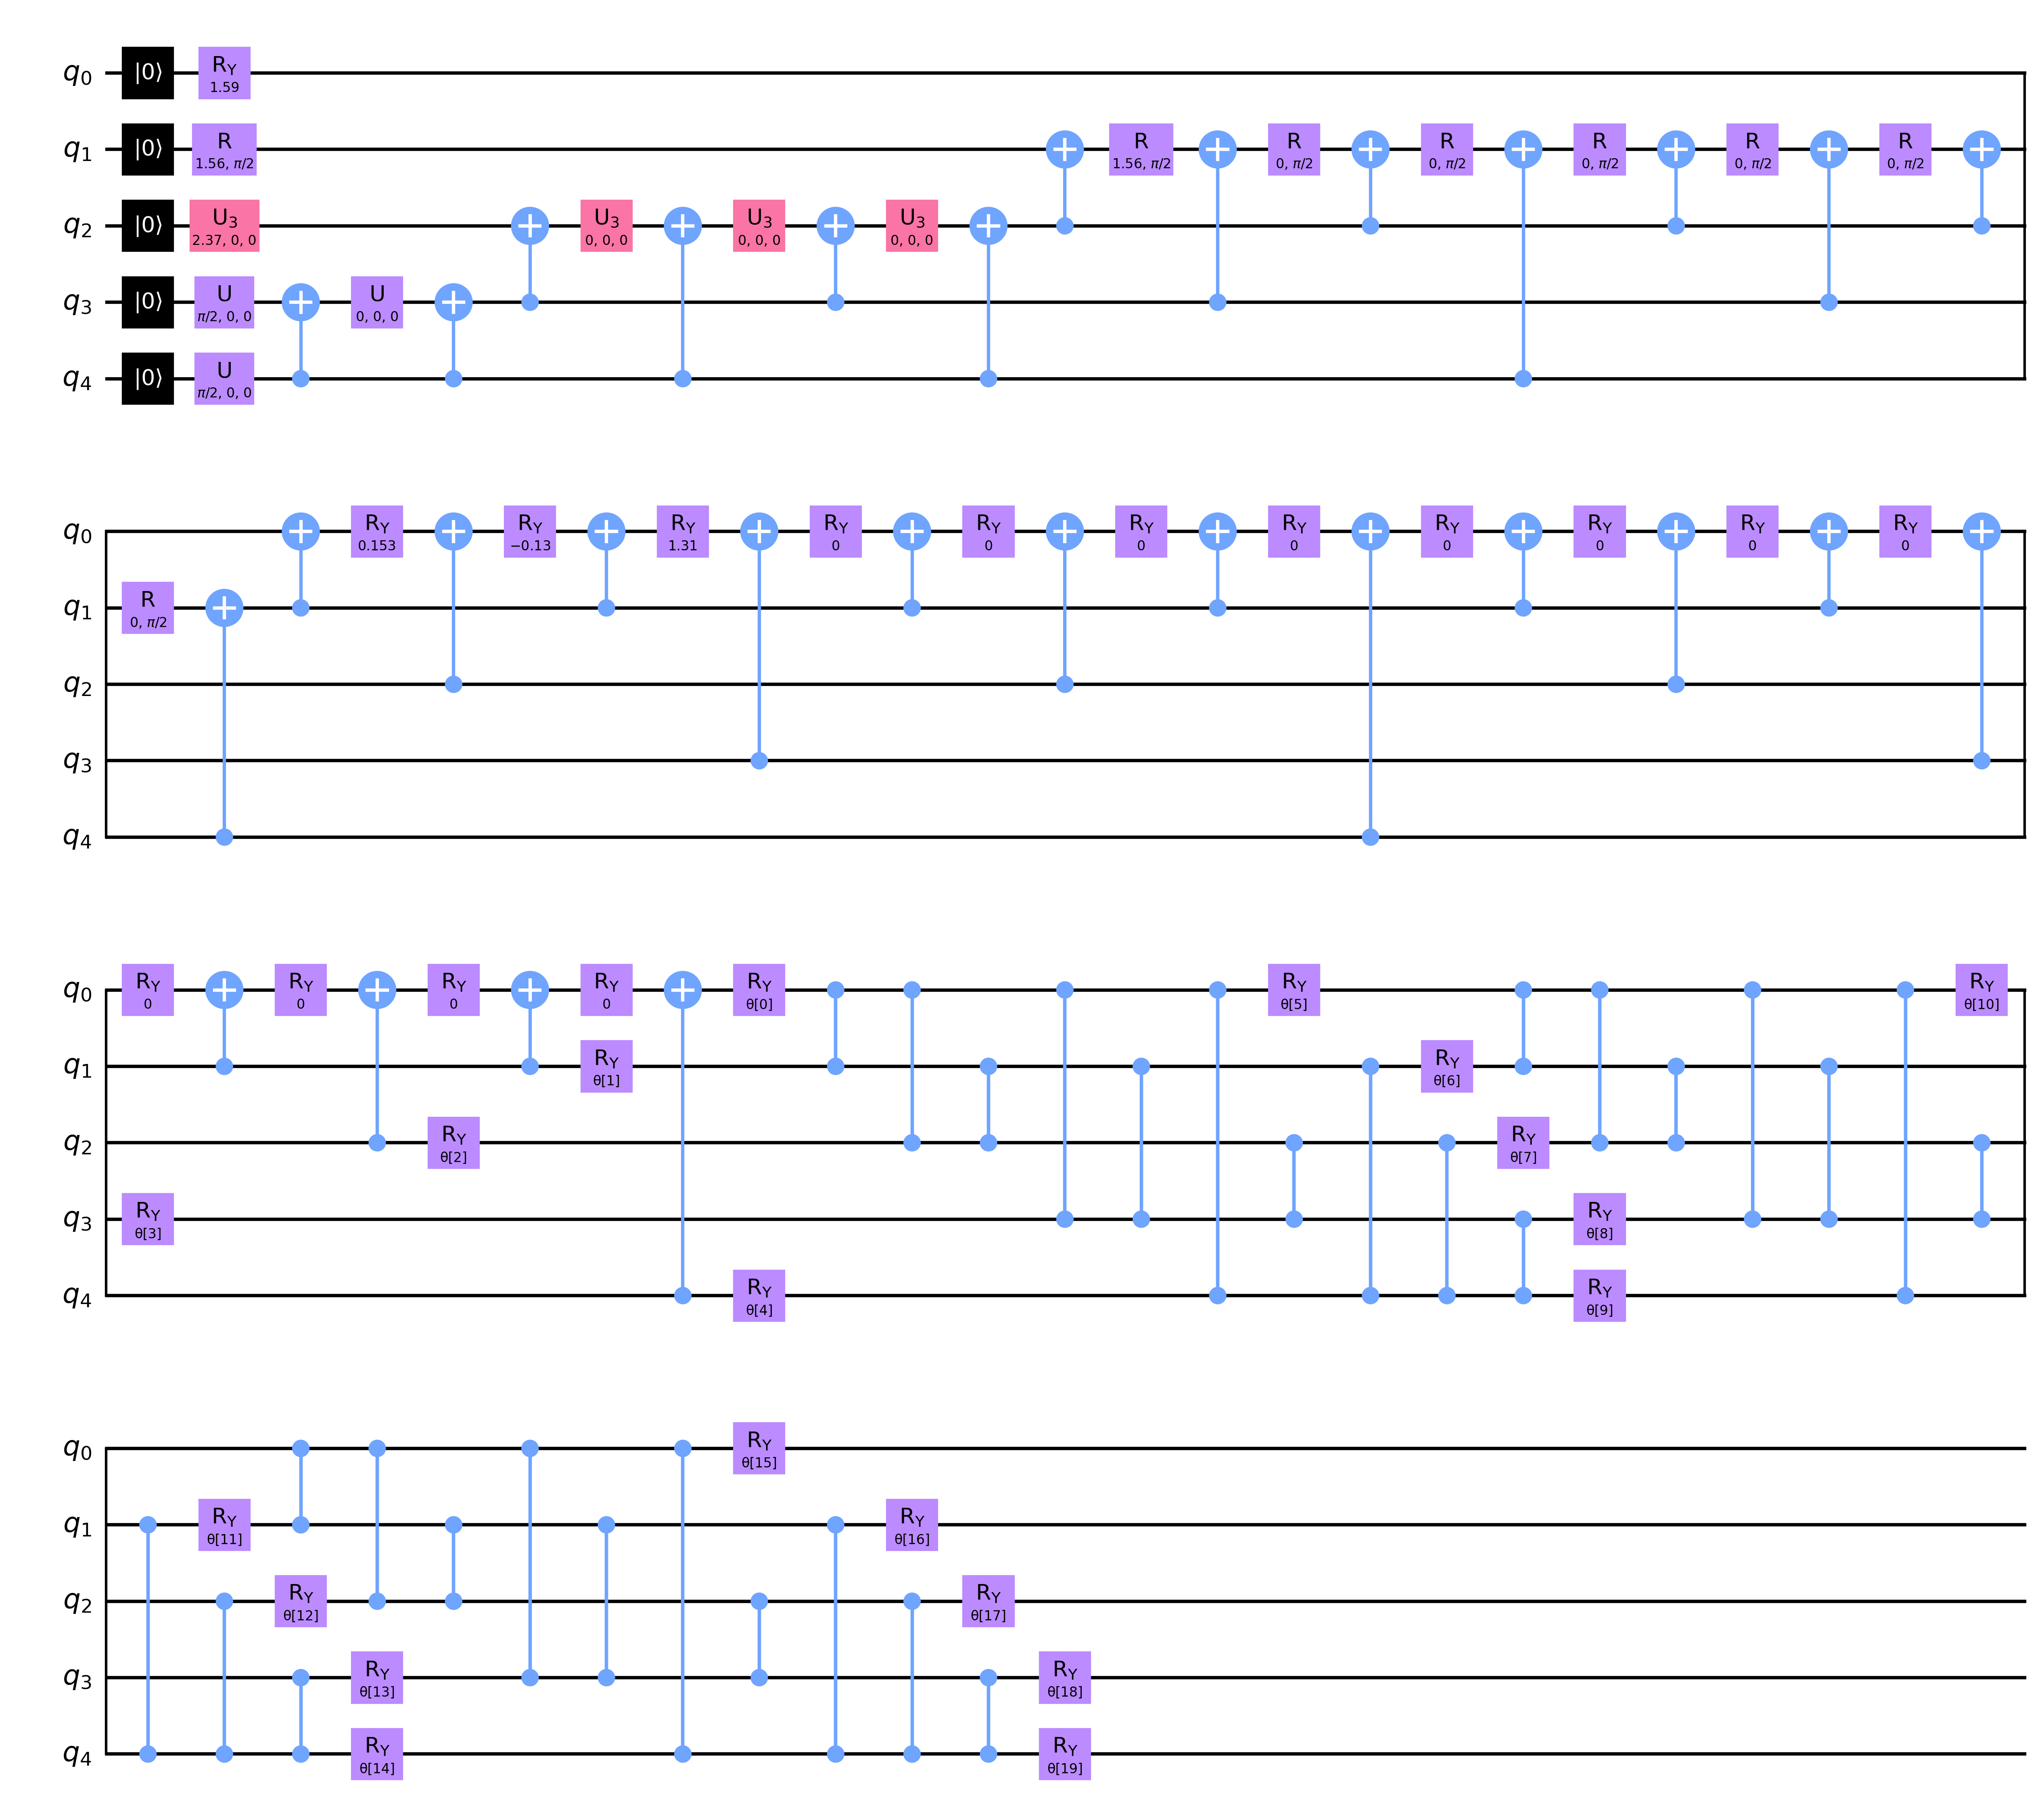

In [12]:
ansatz4 = QuantumCircuit(5)
ansatz4.initialize(eigvec_approx)
ansatz4 = ansatz4.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()

ansatz4 = ansatz4.compose(TwoLocal(5, rotation_blocks=['ry'], entanglement_blocks='cz', entanglement='full', reps=3).decompose())
ansatz4.draw(output='mpl')

In [16]:
optimizers = [COBYLA(maxiter=8000), L_BFGS_B(maxfun=8000), SLSQP(maxiter=1000), NELDER_MEAD(maxfev=8000)]
# from qiskit.algorithms.optimizers import NELDER_MEAD
# optimizers = [SLSQP(maxiter=600)]
converge_cnts4 = np.empty([len(optimizers)], dtype=object)
converge_vals4 = np.empty([len(optimizers)], dtype=object)

repeat = 3
params = None
# params = np.array([0.0 for i in range(ansatz4.num_parameters)])
for i, optimizer in enumerate(optimizers):
    print('Optimizer: {}        '.format(type(optimizer).__name__))
    algorithm_globals.random_seed = 42

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print(f'\r{eval_count}, {mean}', end='')
    
    best_res4 = None
    for j in range(repeat):
        counts = []
        values = []
        vqe = VQE(ansatz4, optimizer, callback=store_intermediate_result, initial_point=params, 
                quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=h_dvr_pauli)
        print()

        if (best_res4 is None) or (values[-1] < best_res4):
            best_res4 = values[-1]
            converge_cnts4[i] = np.asarray(counts)
            converge_vals4[i] = np.asarray(values)
print('\nOptimization complete      ')

Optimizer: COBYLA        
8000, -87.924166742984346
6204, -86.79922331262804
8000, -86.92157496465849
Optimizer: L_BFGS_B        
8001, -88.14345978481894
8001, -87.60279931920967
8001, -88.11117435373919
Optimizer: SLSQP        
2783, -88.15490820367768
2672, -88.07566400284419
3598, -87.88453433193853
Optimizer: NELDER_MEAD        
8000, -78.931787941564155
8000, -86.124766492254946
8000, -83.251464703947066

Optimization complete      


COBYLA -87.9241667429843 0.3026853026610894
L_BFGS_B -88.14345978481894 0.08339226082644302
SLSQP -88.15490820367768 0.07194384196770898
NELDER_MEAD -86.1247664922549 2.1020855533904808
0.031053018200125848


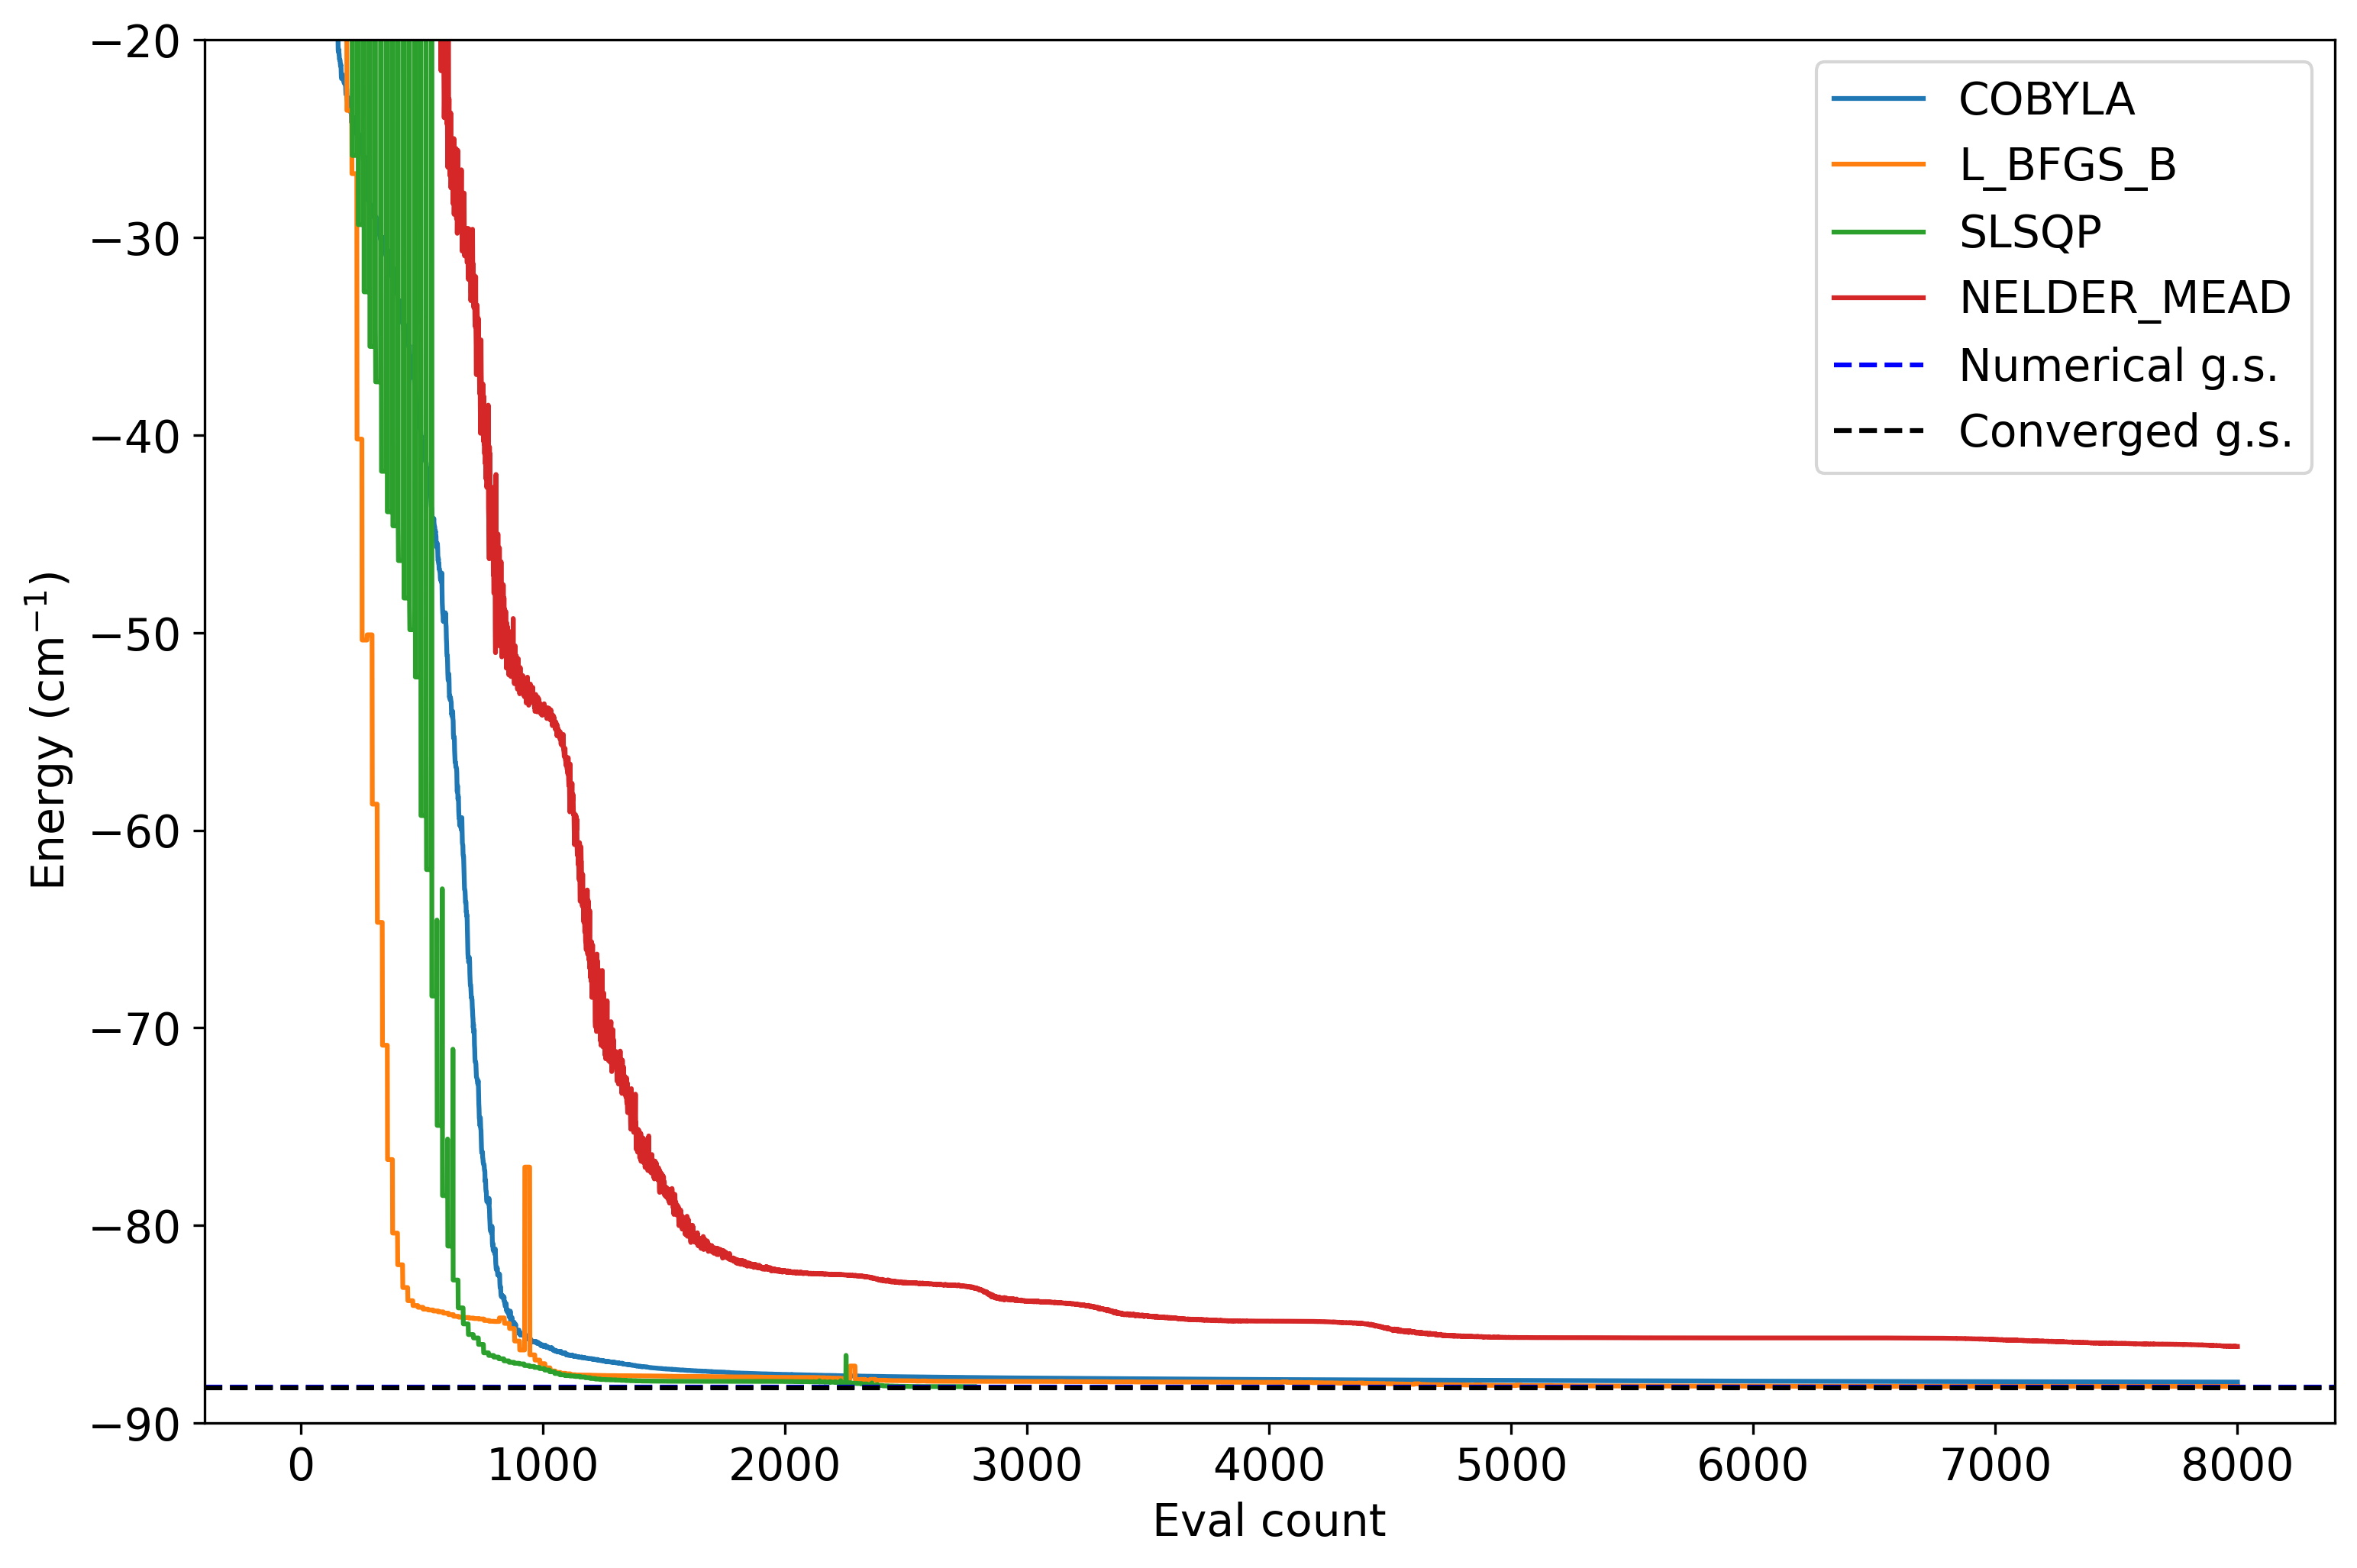

In [17]:
import pylab

ref = -88.22685204564539
# print(converge_cnts2, converge_vals4)
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    print(type(optimizer).__name__, converge_vals4[i][-1], abs(ref - converge_vals4[i][-1]))
    pylab.plot(converge_cnts4[i], converge_vals4[i], label=type(optimizer).__name__)
# pylab.axhline(eigvals[0])

print(abs(ref - eigvals[0]))
pylab.axhline(eigvals[0], ls='--', c='blue', label='Numerical g.s.')
pylab.axhline(ref, ls='--', c='black', label='Converged g.s.')
pylab.xlabel('Eval count')
pylab.ylabel('Energy (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
# pylab.xlim(800, 1000)
pylab.ylim(-90, -20)
pylab.legend(loc='upper right');

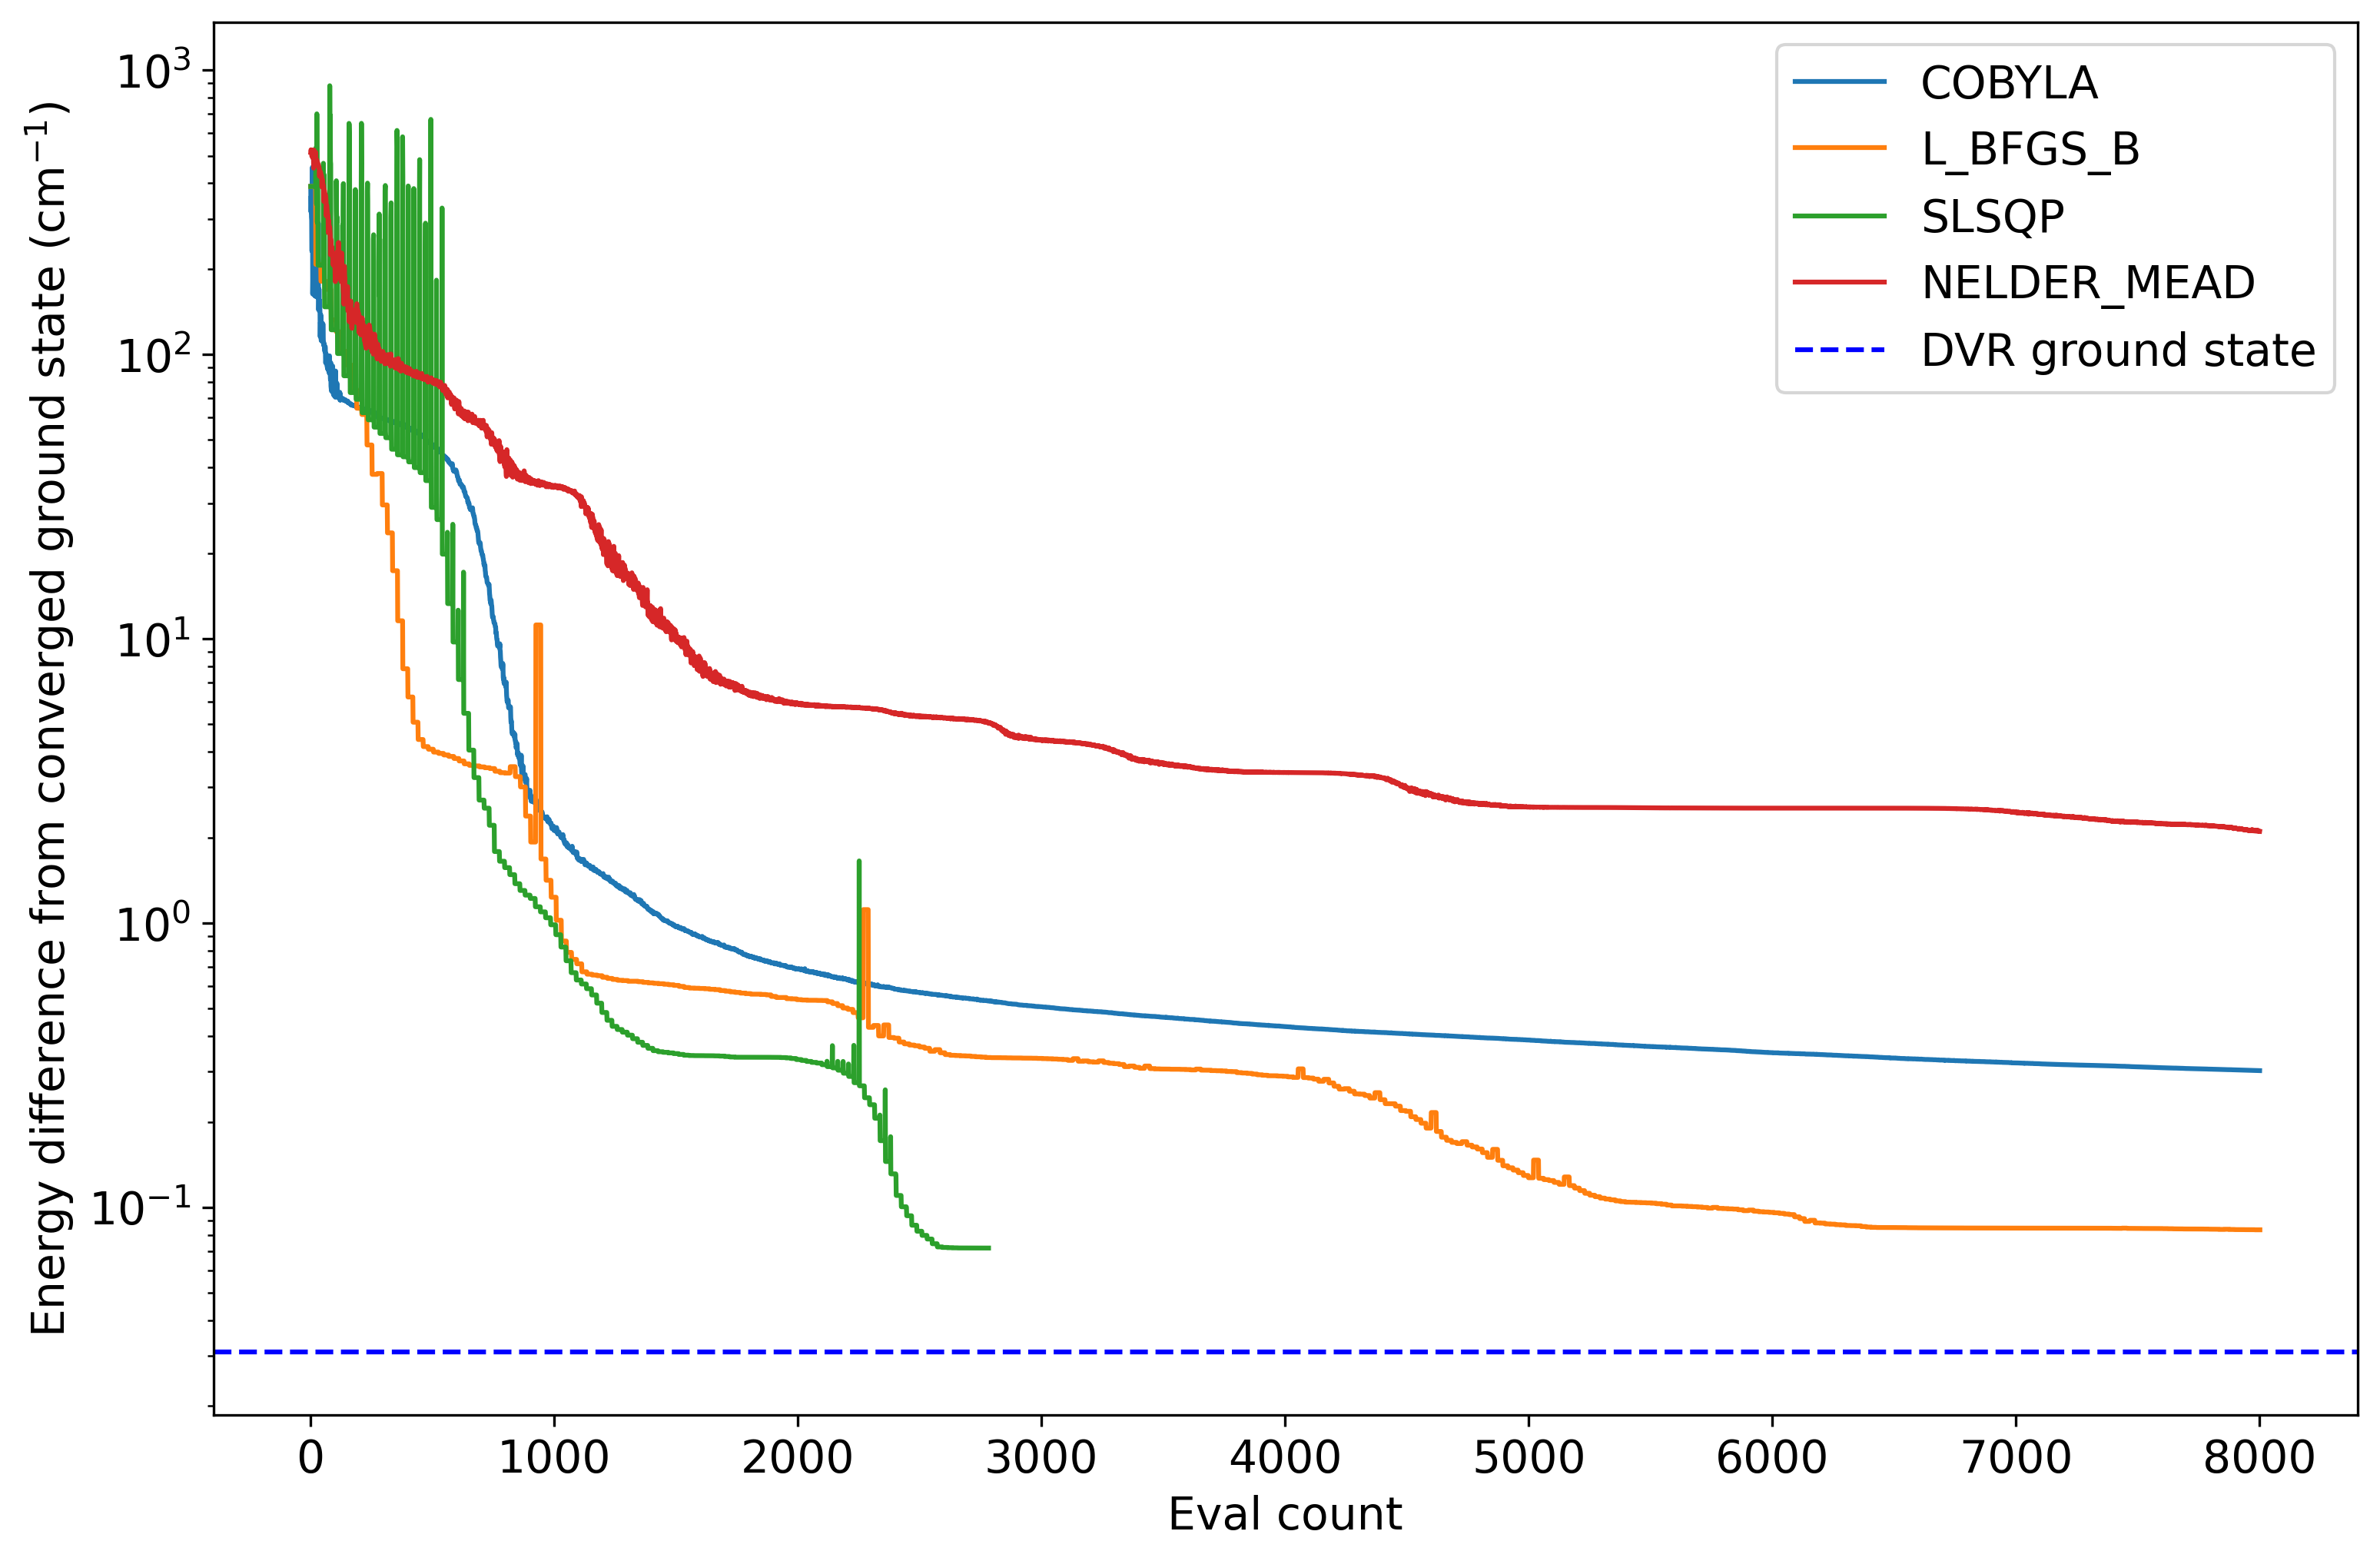

In [18]:
# pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    # pylab.plot(converge_cnts1[i][:], abs(ref - converge_vals1[i][:]), label=type(optimizer).__name__)
    pylab.plot(converge_cnts4[i][:], abs(ref - converge_vals4[i][:]), label=type(optimizer).__name__)
pylab.axhline(abs(ref - eigvals[0]), ls='--', c='blue', label='DVR ground state')
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from converged ground state (cm$^{-1}$)')
# pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
# plt.ylim(0,1)
pylab.legend(loc='upper right');
# print(abs(ref - converge_vals1[:, -1]))